# Reminders on Earthquake Magnitudes:<br>Seismic Moment, Moment Magnitude and Local Magnitude

## I. Introduction

There exist several magnitude scales that measure the size of an earthquake. The local magnitude $M_\ell$, or Richter's magnitude, is often used for small events because it is easy to calculate (however, uncertainties are often large!). The moment magnitude $M_w$ is the only magnitude that relates unambiguously to some physical earthquake parameter, the seismic moment $M_0$. Estimating the moment magnitude $M_w$ requires to observe the low frequencies of the radiated waves, which is often challenging for small events for which low frequencies are under the noise level. In this notebook, we will see how to use tools from the `BPMF.spectrum` module to estimate moment and local magnitudes.


## II.Moment Magnitude $M_w$

For events that were accurately relocated ($h_{max,unc} < 5$ km) with `NonLinLoc`, we can try to estimate their seismic moment $M_0$ and moment magnitude $M_w$ by fitting their network-averaged, path-corrected displacement spectrum with the omega-square model (Brune or Boatwright model).

We recall that (note that $\log$ is the base 10 logarithm):
$$ M_w = \frac{2}{3} \left( \log M_0 - 9.1 \right)\quad (1), $$
with $M_0$ in N.m.

Models of displacement spectra in the far-field predict the shape:
$$ S(f) = \dfrac{\Omega_0}{\left( 1 + (f/f_c)^{\gamma n} \right)^{1/\gamma}} \exp \left( - \dfrac{\pi \tau^{P/S}(x, \xi) f}{Q^{P/S}} \right)\quad (2).$$
Equation (2) is a general expression where $f_c$ is the corner frequency and $n$ controls the high-frequency fall-off rate of the spectrum (typically $n \approx 2$) and $\gamma$ controls the sharpness of the spectrum's corner. The pre-exponential term is the source term and the exponential term is attenuation.  $\tau^{P/S}(x, \xi)$ is the P/S travel time from source location $\xi$ to receiver location $x$, and $Q^{P/S}$ is the P/S attenuation factor. Two special cases of (2) are:
- The Brune spectrum ($n=2$, $\gamma = 1$):
$$ S_{\mathrm{Brune}}(f) = \dfrac{\Omega_0}{1 + (f/f_c)^{2}} \exp \left( - \dfrac{\pi \tau^{P/S}(x, \xi) f}{Q^{P/S}} \right)\quad (3)$$
- Boatwright's spectrum ($n=2$, $\gamma=2$):
$$ S_{\mathrm{Boatwright}}(f) = \dfrac{\Omega_0}{\left( 1 + (f/f_c)^{2 n} \right)^{1/2}} \exp \left( - \dfrac{\pi \tau^{P/S}(x, \xi) f}{Q^{P/S}} \right)\quad (4)$$

The low-frequency plateau $\Omega_0$ is proportional to the seismic moment $M_0$.

$$ \Omega^{P/S}_0 = \dfrac{M_0 R^{P/S}}{4 \pi \sqrt{\rho(\xi) \rho(x) v_{P/S}(\xi) v_{P/S}(x) } v_{P/S}^2(\xi) \mathcal{R}_{P/S}(x, \xi)}\quad (5). $$

In Equation (5), the P/S superscript is for P and S wave, $x$ is the receiver location and $\xi$ is the source location. $R^{P/S}$ is the average radiation pattern ($R^P = \sqrt{4/15}$ and $R^S = \sqrt{2/5}$, see Aki and Richards, 2002), $\rho$ and $v_{P/S}$ are the medium density and P/S-wave velocity at the source, respectively, $\mathcal{R}_{P/S}(x, \xi)$ is the P/S ray length (which can be approximated by $r$, the source-receiver distance). More details in Aki and Richards, 2002 and Boatwright, 1978.

Given $u(f)$ is the observed displacement spectrum, the propagation-corrected spectrum, $\tilde{u}(f)$, is thus:
$$ \tilde{u}(f) = u(f) \dfrac{4 \pi \sqrt{\rho(\xi) \rho(x) v_{P/S}(\xi) v_{P/S}(x) } v_{P/S}^2(\xi) \mathcal{R}_{P/S}(x, \xi)}{R^{P/S}} \exp \left( \dfrac{\pi \tau^{P/S}(x, \xi) f}{Q^{P/S}} \right)\quad (6),$$
and the low-frequency values of $\tilde{u}(f)$ directly reads as the seismic moment, $M_0$.

## III. Local Magnitude $M_L$

The local magnitude was initially introduced by Richter (1935) as the log ratio of peak displacement amplitudes between two earthquakes:
$$ M_L = \log \left( \dfrac{A(X)}{A_0(X)} \right),\quad (6) $$
which results in an empirical formula correcting for the source-receiver epicentral distance $X$:
$$ M_L = \log A(X) + \alpha \log X + \beta,\quad (7)$$
where $\alpha$ and $\beta$ and region-specific parameters (see Peter Shearer's Introduction to Seismology book, Equations 9.68 and 9.69). $\alpha \log X$ is an empirical correction for attenuation and geometrical spreading. The issue with the traditional definition of local magnitude is that it applies to a fixed frequency band whereas 1) attenuation is frequency-dependent  and 2) as detectable magnitude thresholds keep decreasing, one must choose the frequency band where signal-to-noise ratio (SNR) is above 1, otherwise the magnitude estimate is meaningless. Richter himself was concerned about choosing a consistent seismic phase with consistent dominant frequency across earthquakes. It must also be said that Richter's pioneering work was done in the Western US with sparse seismic networks. Therefore, epicentral distances were usually much greater than depths and it made sense to consider epicentral rather than hypocentral distances, especially given the large uncertainties in depth estimates.

These issues make it difficult to relate local magnitudes to seismic moments, which is **crucial if one wants to interpret the exponential distribution of magnitudes (Gutenberg-Richter law) in terms of a power-law distribution of seismic moments**. It appears that the local magnitude scale may not be the most appropriate scale for small earthquakes.

## IV. Approximate Moment Magnitude $M_{w^*}$

To address the above‐mentioned issues, we need to know at which frequency peak displacement is measured and apply the appropriate attenuation correction for this frequency. In fact, the displacement spectrum $u(f)$ is nothing but the value of peak displacement per unit bandwidth at a given frequency $f$. We can therefore use the propagation-corrected spectrum $\tilde{u}(f)$ as a measure of peak displacement corrected for geometrical spreading and attenuation. Any value taken below the corner frequency ($f < f_c$) estimates the seismic moment $M_0$. With small magnitude earthquakes, the signal-to-noise ratio of $u(f)$ is typically too low to observe the displacement spectrum over a wide enough bandwidth to be able to fit the Brune or Boatwright model. However, a few frequency bins may be above the noise level, and we propose to focus on those to estimate the seismic moment. We therefore introduce an approximate moment magnitude $M_{w^*}$.

Among these above-noise frequency bins, $f_{\mathrm{valid}}$, we use the logarithm of the lowest frequency bin, $f_{\mathrm{valid}}^{-}$, of the propagation-corrected displacement spectrum (Eq. (6)), $\log \tilde{u}(f_{\mathrm{valid}}^{-})$, as the basis for our local magnitude $M_{w^*}$:
$$ M_{w^*} = A \log \tilde{u}(f_{\mathrm{valid}}^{-}) + B.$$

- Why the lowest frequency bin? Because it has more chances to verify $f_{\mathrm{valid}}^{-} < f_c$ and, thus, to yield a correct estimate of the seismic moment.
- $f_{\mathrm{valid}}^{-}$ may still be above $f_c$, leading to moment saturation. However, SNR issues are likely with small events, which are those events that have a large corner frequency $f_c$.
- The value of $A$ determines the magnitude-moment scaling.
- To match the moment magnitude-seismic moment scaling (see Eq. (1)), we choose $A = 2/3$ and $B = -\frac{2}{3} \times 9.1 = -6.0666$.

References
----------

Aki, K., & Richards, P. G. (2002). Quantitative seismology.

Boatwright, J. (1978). Detailed spectral analysis of two small New York State earthquakes. Bulletin of the Seismological Society of America, 68(4), 1117-1131.

Richter, Charles F (1935). An instrumental earthquake magnitude scale. Bulletin of the seismological society
of America.

Shearer, Peter M. Introduction to seismology. Cambridge university press, 2019.

# Magnitude Computation

In [1]:
%reload_ext autoreload
%autoreload 2


import os
# choose the number of threads you want to limit the computation to
n_CPUs = 24
os.environ["OMP_NUM_THREADS"] = str(n_CPUs)

import BPMF
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from BPMF.data_reader_examples import data_reader_mseed
from time import time as give_time

In [2]:
INPUT_DB_FILENAME = "final_catalog.h5"
NETWORK_FILENAME = "network.csv"

In [3]:
net = BPMF.dataset.Network(NETWORK_FILENAME)
net.read()

## Load the metadata of the previously detected events

This is similar to what we did in 6_relocate.

In [4]:
events = []
with h5.File(os.path.join(BPMF.cfg.OUTPUT_PATH, INPUT_DB_FILENAME), mode="r") as fin:
    for group_id in fin.keys():
        events.append(
            BPMF.dataset.Event.read_from_file(
                INPUT_DB_FILENAME,
                db_path=BPMF.cfg.OUTPUT_PATH,
                gid=group_id,
                data_reader=data_reader_mseed
            )
        )
        # set the source-receiver distance as this is an important parameter
        # to know to correct for geometrical spreading
        events[-1].set_source_receiver_dist(net)
        if not hasattr(events[-1], "arrival_times"):
            events[-1].set_arrival_times_from_moveouts(verbose=0)
        # set the default moveouts to the theoretical times, that is, those computed in the velocity models 
        events[-1].set_moveouts_to_theoretical_times()
        # when available, set the moveouts to the values defined by the empirical (PhaseNet) picks
        events[-1].set_moveouts_to_empirical_times()

print(f"Loaded {len(events)} events.")

Loaded 60 events.


In [5]:
for i, ev in enumerate(events):
    print(i, ev.origin_time)

0 2012-07-26T00:58:16.160000Z
1 2012-07-26T01:16:29.640000Z
2 2012-07-26T01:18:32.520000Z
3 2012-07-26T01:47:30.080000Z
4 2012-07-26T02:22:49.440000Z
5 2012-07-26T01:02:52.920000Z
6 2012-07-26T03:00:38.720000Z
7 2012-07-26T03:32:50.800000Z
8 2012-07-26T03:38:13.200000Z
9 2012-07-26T13:48:32.440000Z
10 2012-07-26T13:50:18.080000Z
11 2012-07-26T13:53:31.320000Z
12 2012-07-26T01:09:15.880000Z
13 2012-07-26T01:10:21.800000Z
14 2012-07-26T01:15:54.240000Z
15 2012-07-26T01:39:55.440000Z
16 2012-07-26T01:52:36.480000Z
17 2012-07-26T02:24:36.480000Z
18 2012-07-26T01:03:46.920000Z
19 2012-07-26T01:12:32.880000Z
20 2012-07-26T01:15:15.000000Z
21 2012-07-26T00:58:11.080000Z
22 2012-07-26T04:45:03.800000Z
23 2012-07-26T13:51:58.160000Z
24 2012-07-26T13:54:54.240000Z
25 2012-07-26T13:56:54.320000Z
26 2012-07-26T01:09:26.000000Z
27 2012-07-26T01:10:22.080000Z
28 2012-07-26T15:06:20.160000Z
29 2012-07-26T17:28:20.320000Z
30 2012-07-26T00:20:43.400000Z
31 2012-07-26T01:58:19.720000Z
32 2012-07-26T02:3

## Moment magnitude estimation

In this section, we will demonstrate the workflow we adopt to compute the moment magnitude of each event. It consists in:
- Extracting short windows around the P and S waves, as well as a noise window taken before the P wave.
- Correcting for instrument response and integrating velocity to obtain the displacement seismograms.
- Computing the displacement noise/P/S spectra on each channel using the traditional vs advanced technique.
- Correcting for the path effects (geometrical spreading and attenuation).
- Averaging the displacement spectrum over the network.
- Fitting the displacement spectrum with a model of our choice (here, the Boatwright model).

### Conventional method: Example with a single event

In [6]:
#         waveform extraction parameters
# PHASE_ON_COMP: dictionary defining which moveout we use to extract the waveform
PHASE_ON_COMP_S = {"N": "S", "1": "S", "E": "S", "2": "S", "Z": "S"}
PHASE_ON_COMP_P = {"N": "P", "1": "P", "E": "P", "2": "P", "Z": "P"}

# BUFFER_SEC: duration, in sec, of time window taken before and after the window of interest
#             which we need to avoid propagating the pre-filtering taper operation into our
#             amplitude readings
BUFFER_SEC = 3.0
# OFFSET_PHASE: dictionary defining the time offset taken before a given phase
#               for example OFFSET_PHASE["P"] = 1.0 means that we extract the window
#               1 second before the predicted P arrival time
OFFSET_PHASE = {"P": 0.5 + BUFFER_SEC, "S": 0.5 + BUFFER_SEC}
DURATION_SEC = 3.0 + 2.0 * BUFFER_SEC
OFFSET_OT_SEC_NOISE = DURATION_SEC 

TIME_SHIFTED = True
DATA_FOLDER = "raw"
DATA_READER = data_reader_mseed
ATTACH_RESPONSE = True

#       spectral inversion parameters
SPECTRAL_MODEL = "boatwright"
RHO_SOURCE_KGM3 = 2700.0
VS_SOURCE_MS = 3500.0
VP_SOURCE_MS = VS_SOURCE_MS * 1.72
RHO_RECEIVER_KGM3 = 2600.0
VS_RECEIVER_MS = 2800.0
VP_RECEIVER_MS = VS_RECEIVER_MS * 1.72
FREQ_MIN_HZ = 0.5
FREQ_MAX_HZ = 20.
NUM_FREQS = 100
SNR_THRESHOLD = 10.
MIN_NUM_VALID_CHANNELS_PER_FREQ_BIN = 5
MIN_FRACTION_VALID_POINTS_BELOW_FC = 0.20
MAX_RELATIVE_DISTANCE_ERR_PCT = 33.
NUM_CHANNEL_WEIGHTED_FIT = True

In [7]:
EVENT_IDX = 13
event = events[EVENT_IDX]
print(f"The maximum horizontal location uncertainty of event {EVENT_IDX} is {event.hmax_unc:.2f}km.")
print(f"The minimum horizontal location uncertainty of event {EVENT_IDX} is {event.hmin_unc:.2f}km.")
print(f"The maximum vertical location uncertainty is {event.vmax_unc:.2f}km.")

The maximum horizontal location uncertainty of event 13 is 1.77km.
The minimum horizontal location uncertainty of event 13 is 1.30km.
The maximum vertical location uncertainty is 2.65km.


In the following, we define 3 `obspy.Stream` instances with the noise, P-wave and S-wave traces. Here, it is important to identify the clipped waveforms and set them to zero so that we don't use them in the future. The identification of clipped waveforms is based on a simple kurtosis test (kurtosis is low for clipped waveforms because the extremum values are often reached).

In [8]:
#                 extract waveforms
# first, read short extract before signal as an estimate of noise
event.read_waveforms(
    DURATION_SEC,
    time_shifted=False,
    data_folder=DATA_FOLDER,
    offset_ot=OFFSET_OT_SEC_NOISE,
    attach_response=ATTACH_RESPONSE,
)
noise = event.traces.copy()

# then, read signal
event.read_waveforms(
    DURATION_SEC,
    phase_on_comp=PHASE_ON_COMP_P,
    offset_phase=OFFSET_PHASE,
    time_shifted=TIME_SHIFTED,
    data_folder=DATA_FOLDER,
    attach_response=ATTACH_RESPONSE,
)
event.zero_out_clipped_waveforms(kurtosis_threshold=-1)
p_wave = event.traces.copy()

event.read_waveforms(
    DURATION_SEC,
    phase_on_comp=PHASE_ON_COMP_S,
    offset_phase=OFFSET_PHASE,
    time_shifted=TIME_SHIFTED,
    data_folder=DATA_FOLDER,
    attach_response=ATTACH_RESPONSE,
)
event.zero_out_clipped_waveforms(kurtosis_threshold=-1)
s_wave = event.traces.copy()

# correct for instrument response and integrate to get displacement seismograms
for st in [noise, p_wave, s_wave]:
    for tr in st:
        fnyq = tr.stats.sampling_rate / 2.
        pre_filt = [ 
                1. / DURATION_SEC, 
                1.05 / DURATION_SEC,
                0.95 * fnyq,
                0.98 * fnyq
                ]
        tr.detrend("constant")
        tr.detrend("linear")
        tr.taper(0.25, type="cosine")
        tr.remove_response(
            pre_filt=pre_filt,
            zero_mean=False,
            taper=False,
            #taper_fraction=0.25,
            output="DISP",
            plot=False,
                )
        tr.trim(
                starttime=tr.stats.starttime + BUFFER_SEC,
                endtime=tr.stats.endtime - BUFFER_SEC
                )

We can now compute the velocity spectra on each channel.

In [9]:
spectrum = BPMF.spectrum.Spectrum(event=event)
spectrum.compute_spectrum(noise, "noise", alpha=0.15)
spectrum.compute_spectrum(p_wave, "p", alpha=0.15)
spectrum.compute_spectrum(s_wave, "s", alpha=0.15)

spectrum.set_target_frequencies(FREQ_MIN_HZ, FREQ_MAX_HZ, NUM_FREQS)
spectrum.resample(spectrum.frequencies, spectrum.phases)
spectrum.compute_signal_to_noise_ratio("p")
spectrum.compute_signal_to_noise_ratio("s")


Let's plot the velocity spectra and the signal-to-noise ratio (SNR) spectra.

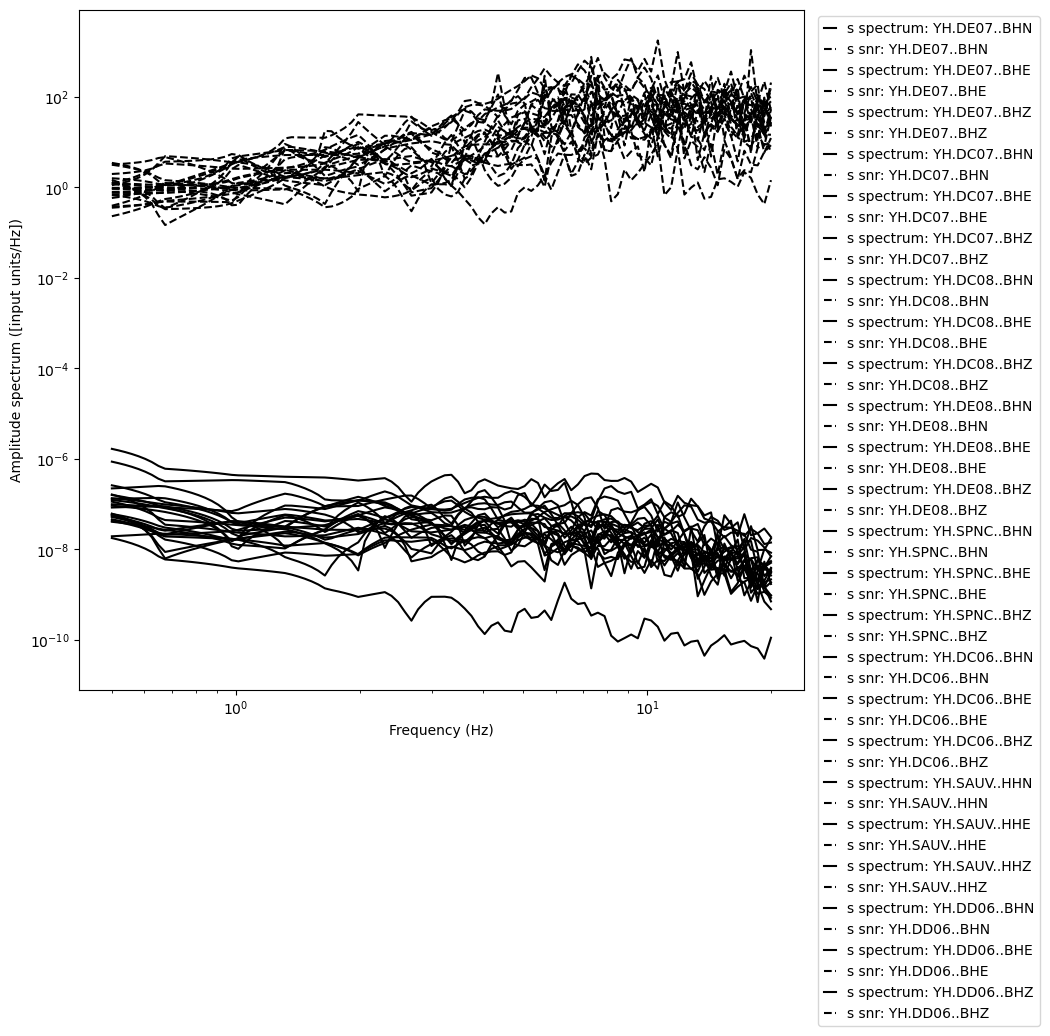

In [10]:
phase_to_plot = "s"
fig = spectrum.plot_spectrum(phase_to_plot, plot_snr=True)

Before correcting for geometrical spreading, we need to build an attenuation model. In general, body-wave attenuation in the lithosphere is described by he quality factor $Q$, which is related to frequency by (Aki, 1980):
$$ Q \propto f^{n},\ 0.5 \leq n \leq 0.8\quad (6)$$

To build a simple model of attenuation, we assume that $Q^P = Q^S = Q_0 f^n$. We search for an adequate value of $Q_0$ and $n$ in the literature. $Q_0 = 33$ and $n = 0.75$ reproduce reasonably well the curves shown in Izgi et al., 2020.

References:

Aki, K. (1980). Attenuation of shear-waves in the lithosphere for frequencies from 0.05 to 25 Hz. Physics of the Earth and Planetary Interiors, 21(1), 50-60.

Izgi, G., Eken, T., Gaebler, P., Eulenfeld, T., & Taymaz, T. (2020). Crustal seismic attenuation parameters in the western region of the North Anatolian Fault Zone. Journal of Geodynamics, 134, 101694.

In [11]:
Q_1Hz = 33.
n = 0.75
Q = Q_1Hz * np.power(spectrum.frequencies, n)

In [12]:
spectrum.set_Q_model(Q, spectrum.frequencies)
spectrum.compute_correction_factor(
    RHO_SOURCE_KGM3, RHO_RECEIVER_KGM3,
    VP_SOURCE_MS, VP_RECEIVER_MS,
    VS_SOURCE_MS, VS_RECEIVER_MS
)


Relative error on M0: 3.65%
Relative error on fc: 3.20%
Relative error on M0: 4.00%
Relative error on fc: 3.04%


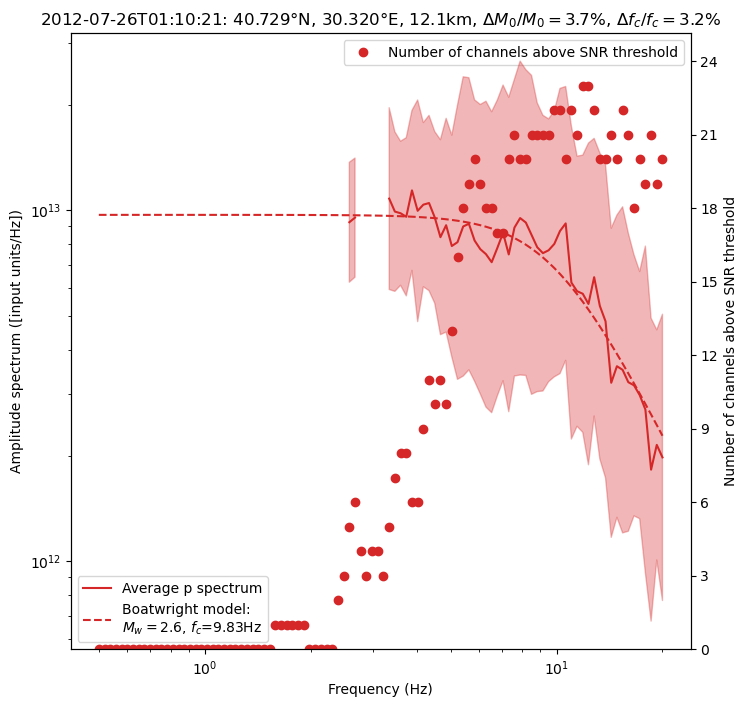

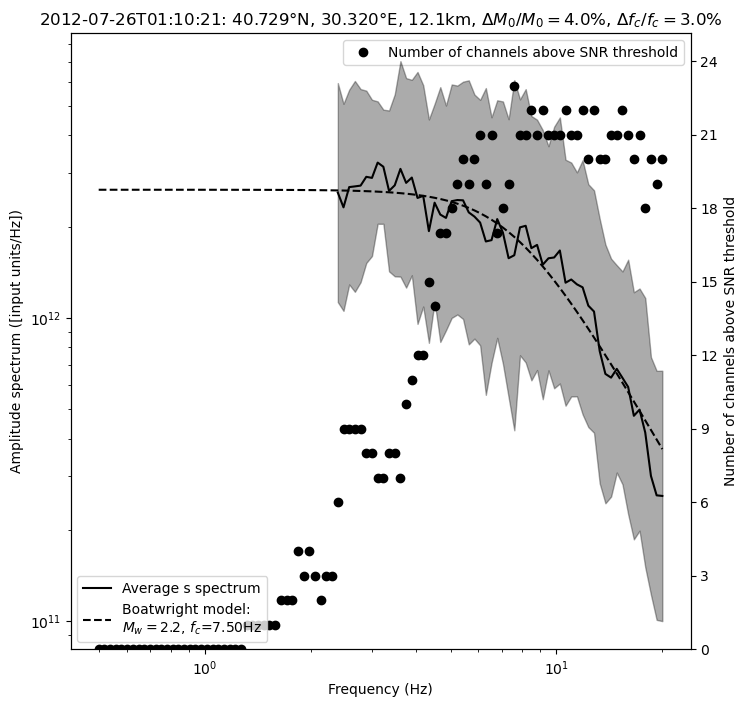

In [13]:
source_parameters = {}
for phase_for_mag in ["p", "s"]:
    spectrum.compute_network_average_spectrum(
        phase_for_mag,
        SNR_THRESHOLD,
        min_num_valid_channels_per_freq_bin=MIN_NUM_VALID_CHANNELS_PER_FREQ_BIN,
        max_relative_distance_err_pct=MAX_RELATIVE_DISTANCE_ERR_PCT,
        verbose=1
        )
    # spectrum.integrate(phase_for_mag, average=True)
    spectrum.fit_average_spectrum(
            phase_for_mag,
            model=SPECTRAL_MODEL,
            # min_fraction_valid_points_below_fc=MIN_FRACTION_VALID_POINTS_BELOW_FC,
            min_fraction_valid_points_below_fc=0.,
            weighted=NUM_CHANNEL_WEIGHTED_FIT,
            )
    if spectrum.inversion_success:
        rel_M0_err = 100.*spectrum.M0_err/spectrum.M0
        rel_fc_err = 100.*spectrum.fc_err/spectrum.fc
        if rel_M0_err > 10. or spectrum.fc < 0. or spectrum.fc > 25.:
            continue
        print(f"Relative error on M0: {rel_M0_err:.2f}%")
        print(f"Relative error on fc: {rel_fc_err:.2f}%")
        # event.set_aux_data({f"Mw_{phase_for_mag}": spectrum.Mw})
        figtitle = (f"{event.origin_time.strftime('%Y-%m-%dT%H:%M:%S')}: "
                    f"{event.latitude:.3f}""\u00b0"
                    f"N, {event.longitude:.3f}""\u00b0"
                    f"E, {event.depth:.1f}km, "
                    r"$\Delta M_0 / M_0=$"f"{rel_M0_err:.1f}%, "
                    r"$\Delta f_c / f_c=$"f"{rel_fc_err:.1f}%")
        source_parameters[f"M0_{phase_for_mag}"] = spectrum.M0
        source_parameters[f"Mw_{phase_for_mag}"] = spectrum.Mw
        source_parameters[f"fc_{phase_for_mag}"] = spectrum.fc
        source_parameters[f"M0_err_{phase_for_mag}"] = spectrum.M0_err
        source_parameters[f"fc_err_{phase_for_mag}"] = spectrum.fc_err
        fig = spectrum.plot_average_spectrum(
                phase_for_mag,
                plot_fit=True,
                figname=f"{phase_for_mag}_spectrum_{EVENT_IDX}",
                figtitle=figtitle,
                figsize=(8, 8),
                plot_std=True,
                plot_num_valid_channels=True,
                )


The significant discrepancy between the P- and S-wave estimates probably comes from the difficulty of separating P and S waves at short distances. Thus, it's better to simply use the S-wave estimate.

In general, if one had good S-wave *and* P-wave spectra, one could produce a single final estimate of the moment magnitude $M_w$ by averaging the P- and S-wave estimates:
$$ M_w = \frac{1}{2} (M_w^P + M_w^S).\quad (7) $$
Using the definition of the moment magnitude, we can derive the following formula for the magnitude error:
$$ d M_w = \frac{1}{3} \left( \frac{dM_0^P}{M_0^P} + \frac{dM_0^S}{M_0^S} \right) $$

### Method from Al-Ismal et al., 2022: Example with a single event

The Al-Ismail et al., 2022, study shows that a higher SNR displacement spectrum can estimated from the peak amplitude of the displacement waveform filtered in multiple frequency bands. This technique is especially interesting for the small magnitude earthquakes we are dealing with.

Reference:

Al‐Ismail, Fatimah, William L. Ellsworth, and Gregory C. Beroza. (2022) "A Time‐Domain Approach for Accurate Spectral Source Estimation with Application to Ridgecrest, California, Earthquakes." Bulletin of the Seismological Society of America.

In [14]:
#         waveform extraction parameters
# PHASE_ON_COMP: dictionary defining which moveout we use to extract the waveform
PHASE_ON_COMP_S = {"N": "S", "1": "S", "E": "S", "2": "S", "Z": "S"}
PHASE_ON_COMP_P = {"N": "P", "1": "P", "E": "P", "2": "P", "Z": "P"}
# BUFFER_SEC: duration, in sec, of time window taken before and after the window of interest
#             which we need to avoid propagating the pre-filtering taper operation into our
#             amplitude readings
BUFFER_SEC = 6.0
# OFFSET_PHASE: dictionary defining the time offset taken before a given phase
#               for example OFFSET_PHASE["P"] = 1.0 means that we extract the window
#               1 second before the predicted P arrival time
OFFSET_PHASE = {"P": 0.5 + BUFFER_SEC, "S": 0.5 + BUFFER_SEC}
DURATION_SEC = 3.0 + 2.0 * BUFFER_SEC
OFFSET_OT_SEC_NOISE = DURATION_SEC 
TIME_SHIFTED = True
DATA_FOLDER = "raw"
DATA_READER = data_reader_mseed
ATTACH_RESPONSE = True

#       multi-band-filtering parameters
FREQUENCY_BANDS = {
    "0.5Hz-1.0Hz": [0.5, 1.0],
    "1.0Hz-2.0Hz": [1.0, 2.0],
    "2.0Hz-4.0Hz": [2.0, 4.0],
    "4.0Hz-8.0Hz": [4.0, 8.0],
    "8.0Hz-16.0Hz": [8.0, 16.0],
    "16.0Hz-32.0Hz": [16.0, 32.0],
}
FILTER_ORDER = 4
USED_COMPONENTS = "[N,E,1,2,Z]"
CENTER_FREQUENCIES = [
    0.5
    * (
        FREQUENCY_BANDS[band][0] + FREQUENCY_BANDS[band][1]
    )
    for band in FREQUENCY_BANDS
]

#       spectral inversion parameters
SPECTRAL_MODEL = "boatwright"
RHO_SOURCE_KGM3 = 2700.0
VS_SOURCE_MS = 3500.0
VP_SOURCE_MS = VS_SOURCE_MS * 1.72
RHO_RECEIVER_KGM3 = 2600.0
VS_RECEIVER_MS = 2800.0
VP_RECEIVER_MS = VS_RECEIVER_MS * 1.72

NUM_FREQS = 20
SNR_THRESHOLD = 10.
MIN_NUM_VALID_CHANNELS_PER_FREQ_BIN = 5
MIN_FRACTION_VALID_POINTS_BELOW_FC = 0.20
MAX_RELATIVE_DISTANCE_ERR_PCT = 33.
NUM_CHANNEL_WEIGHTED_FIT = True

#       attenuation model
Q_1HZ = 33.
N = 0.75

In [15]:
def plot_filtered_traces(spectrum, station_name, noise_spectrum=None):
    import fnmatch
    tr_ids = fnmatch.filter(
            list(spectrum.keys()), f"*{station_name}*"
            )
    num_channels = len(tr_ids)
    if num_channels == 0:
        print(f"Could not find {station_name}")
        return
    num_bands = len(spectrum[tr_ids[0]]["filtered_traces"])
    fig, axes = plt.subplots(
            num=f"filtered_traces_{station_name}",
            ncols=num_channels,
            nrows=num_bands,
            figsize=(16, 3*num_bands)
            )
    for c, trid in enumerate(tr_ids):
        axes[0, c].set_title(trid)
        for i, band in enumerate(spectrum[tr_ids[0]]["filtered_traces"].keys()):
            tr = spectrum[trid]["filtered_traces"][band]
            axes[i, c].plot(
                    tr.times(),
                    tr.data,
                    )
            axes[i, c].text(
                    0.02, 0.05, band, transform=axes[i, c].transAxes
                    )
            if noise_spectrum is not None:
                tr_n = noise_spectrum[trid]["filtered_traces"][band]
                axes[i, c].plot(
                        tr_n.times(),
                        tr_n.data,
                        color="grey",
                        ls="--",
                        zorder=0.1,
                        )

        axes[i, c].set_xlabel("Time (s)")
    return fig


In [16]:
EVENT_IDX = 13
event = events[EVENT_IDX]
print(f"The maximum horizontal location uncertainty of event {EVENT_IDX} is {event.hmax_unc:.2f}km.")
print(f"The minimum horizontal location uncertainty of event {EVENT_IDX} is {event.hmin_unc:.2f}km.")
print(f"The maximum vertical location uncertainty is {event.vmax_unc:.2f}km.")

The maximum horizontal location uncertainty of event 13 is 1.77km.
The minimum horizontal location uncertainty of event 13 is 1.30km.
The maximum vertical location uncertainty is 2.65km.


In [17]:

#                 extract waveforms
# first, read short extract before signal as an estimate of noise
event.read_waveforms(
    DURATION_SEC,
    time_shifted=False,
    data_folder=DATA_FOLDER,
    offset_ot=OFFSET_OT_SEC_NOISE,
    attach_response=ATTACH_RESPONSE,
)
noise = event.traces.copy()

# then, read signal
event.read_waveforms(
    DURATION_SEC,
    phase_on_comp=PHASE_ON_COMP_P,
    offset_phase=OFFSET_PHASE,
    time_shifted=TIME_SHIFTED,
    data_folder=DATA_FOLDER,
    attach_response=ATTACH_RESPONSE,
)
event.zero_out_clipped_waveforms(kurtosis_threshold=-1)
p_wave = event.traces.copy()


event.read_waveforms(
    DURATION_SEC,
    phase_on_comp=PHASE_ON_COMP_S,
    offset_phase=OFFSET_PHASE,
    time_shifted=TIME_SHIFTED,
    data_folder=DATA_FOLDER,
    attach_response=ATTACH_RESPONSE,
)
event.zero_out_clipped_waveforms(kurtosis_threshold=-1)
s_wave = event.traces.copy()

# correct for instrument response and integrate to get displacement seismograms
for st in [noise, p_wave, s_wave]:
    for tr in st:
        fnyq = tr.stats.sampling_rate / 2.
        pre_filt = [ 
                1. / DURATION_SEC, 
                1.05 / DURATION_SEC,
                0.95 * fnyq,
                0.98 * fnyq
                ]
        tr.detrend("constant")
        tr.detrend("linear")
        tr.taper(0.25, type="cosine")
        tr.remove_response(
            pre_filt=pre_filt,
            zero_mean=False,
            taper=False,
            #taper_fraction=0.25,
            output="DISP",
            plot=False,
                )

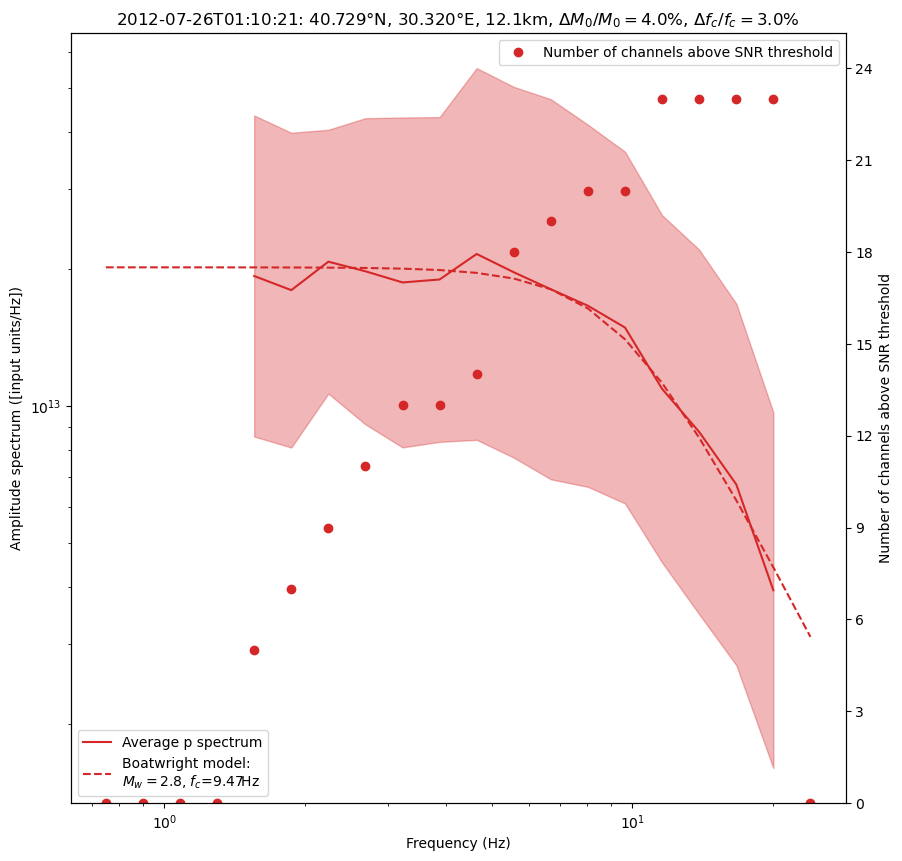

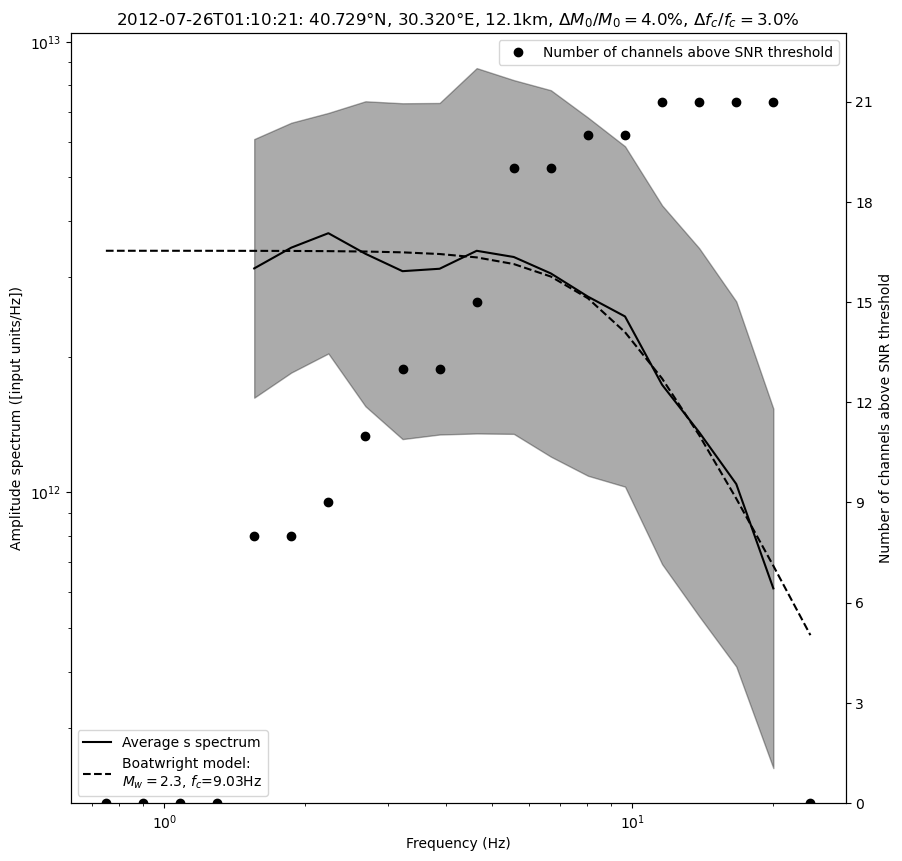

In [18]:
# -----------------------------------------
# now, compute multi-band displacement spectra
# -----------------------------------------
spectrum = BPMF.spectrum.Spectrum(event=event)
spectrum.set_frequency_bands(FREQUENCY_BANDS)
spectrum.compute_multi_band_spectrum(
    noise.select(component=USED_COMPONENTS), "noise", BUFFER_SEC,
    dev_mode=True
)
spectrum.compute_multi_band_spectrum(
    s_wave.select(component=USED_COMPONENTS), "s", BUFFER_SEC,
    dev_mode=True
)
spectrum.compute_multi_band_spectrum(
    p_wave.select(component=USED_COMPONENTS), "p", BUFFER_SEC,
    dev_mode=True
)

#       attenuation model
Q = Q_1HZ * np.power(spectrum.frequencies, N)
spectrum.set_Q_model(Q, spectrum.frequencies)
spectrum.compute_correction_factor(
    RHO_SOURCE_KGM3,
    RHO_RECEIVER_KGM3,
    VP_SOURCE_MS,
    VP_RECEIVER_MS,
    VS_SOURCE_MS,
    VS_RECEIVER_MS,
)

spectrum.set_target_frequencies(
    CENTER_FREQUENCIES[0],
    CENTER_FREQUENCIES[-1],
    NUM_FREQS
)
spectrum.resample(spectrum.frequencies, spectrum.phases)

for phase_for_mag in ["p", "s"]:
    spectrum.compute_signal_to_noise_ratio(phase_for_mag)
    spectrum.compute_network_average_spectrum(
        phase_for_mag,
        SNR_THRESHOLD,
        min_num_valid_channels_per_freq_bin=MIN_NUM_VALID_CHANNELS_PER_FREQ_BIN,
        max_relative_distance_err_pct=MAX_RELATIVE_DISTANCE_ERR_PCT,
    )

    spectrum.fit_average_spectrum(
        phase_for_mag,
        model=SPECTRAL_MODEL,
        min_fraction_valid_points_below_fc=MIN_FRACTION_VALID_POINTS_BELOW_FC,
        weighted=NUM_CHANNEL_WEIGHTED_FIT,
    )

    fig = spectrum.plot_average_spectrum(
        phase_for_mag,
        plot_fit=True,
        figname=f"{phase_for_mag}_spectrum_{event.id}",
        figsize=(10, 10),
        figtitle=figtitle,
        plot_std=True,
        plot_num_valid_channels=True,
    )


Have a look at the bandpass filtered displacement seismograms from which the spectrum was built:

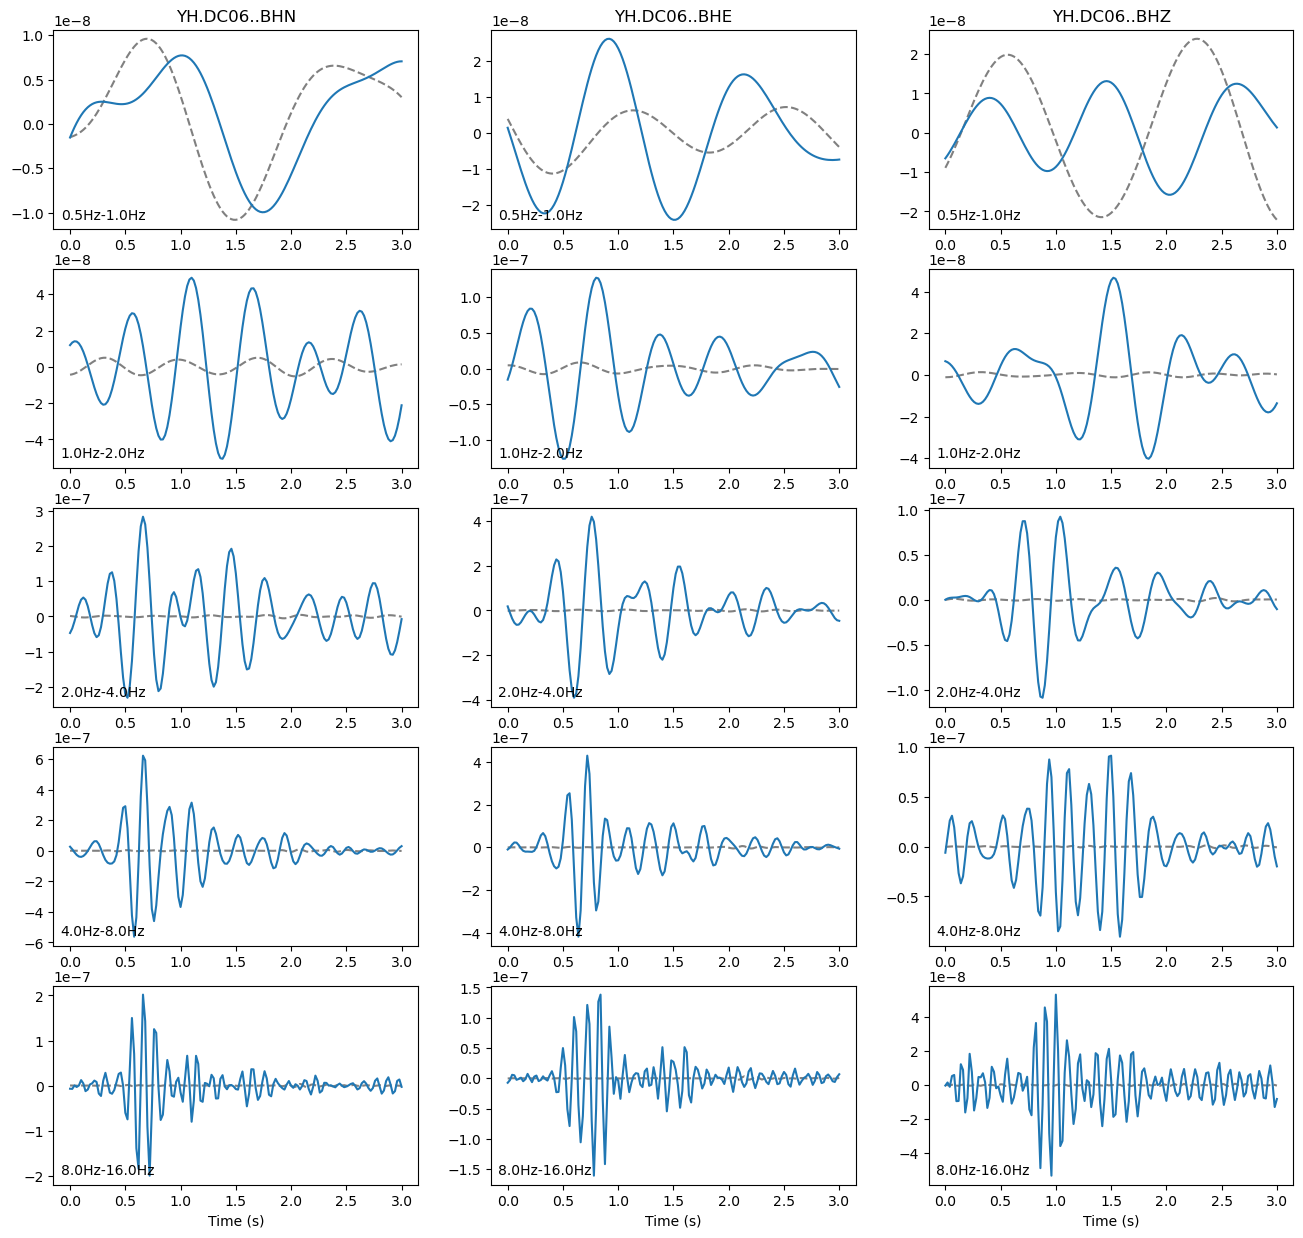

In [19]:
fig = plot_filtered_traces(
    spectrum.s_spectrum, "DC06", noise_spectrum=spectrum.noise_spectrum
    )

Using the Al-Ismail et al., 2022, technique procudes network-averaged displacement spectra that follows the Boatwright model very closely, therefore we prefer it, in general. However, note that the modeled S-wave spectra are very similar with both techniques. 

### Estimate a moment magnitude for every event: Al-Ismail method (preferred)

In [20]:
#         waveform extraction parameters
# PHASE_ON_COMP: dictionary defining which moveout we use to extract the waveform
PHASE_ON_COMP_S = {"N": "S", "1": "S", "E": "S", "2": "S", "Z": "S"}
PHASE_ON_COMP_P = {"N": "P", "1": "P", "E": "P", "2": "P", "Z": "P"}
# BUFFER_SEC: duration, in sec, of time window taken before and after the window of interest
#             which we need to avoid propagating the pre-filtering taper operation into our
#             amplitude readings
BUFFER_SEC = 6.0
# OFFSET_PHASE: dictionary defining the time offset taken before a given phase
#               for example OFFSET_PHASE["P"] = 1.0 means that we extract the window
#               1 second before the predicted P arrival time
OFFSET_PHASE = {"P": 0.5 + BUFFER_SEC, "S": 0.5 + BUFFER_SEC}
DURATION_SEC = 3.0 + 2.0 * BUFFER_SEC
OFFSET_OT_SEC_NOISE = DURATION_SEC 
TIME_SHIFTED = True
DATA_FOLDER = "raw"
DATA_READER = data_reader_mseed
ATTACH_RESPONSE = True

#       multi-band-filtering parameters
FREQUENCY_BANDS = {
    "0.5Hz-1.0Hz": [0.5, 1.0],
    "1.0Hz-2.0Hz": [1.0, 2.0],
    "2.0Hz-4.0Hz": [2.0, 4.0],
    "4.0Hz-8.0Hz": [4.0, 8.0],
    "8.0Hz-16.0Hz": [8.0, 16.0],
    "16.0Hz-32.0Hz": [16.0, 32.0],
}
FILTER_ORDER = 4
USED_COMPONENTS = "[N,E,1,2,Z]"
CENTER_FREQUENCIES = [
    0.5
    * (
        FREQUENCY_BANDS[band][0] + FREQUENCY_BANDS[band][1]
    )
    for band in FREQUENCY_BANDS
]

#       spectral inversion parameters
SPECTRAL_MODEL = "boatwright"
RHO_SOURCE_KGM3 = 2700.0
VS_SOURCE_MS = 3500.0
VP_SOURCE_MS = VS_SOURCE_MS * 1.72
RHO_RECEIVER_KGM3 = 2600.0
VS_RECEIVER_MS = 2800.0
VP_RECEIVER_MS = VS_RECEIVER_MS * 1.72

NUM_FREQS = 20
SNR_THRESHOLD = 10.
MIN_NUM_VALID_CHANNELS_PER_FREQ_BIN = 5
MIN_FRACTION_VALID_POINTS_BELOW_FC = 0.20
MAX_RELATIVE_DISTANCE_ERR_PCT = 33.
NUM_CHANNEL_WEIGHTED_FIT = True

#       attenuation model
Q_1HZ = 33.
N = 0.75

Processing event 0
Class instance does not have a `cov_mat` attribute.
The P-S averaged moment magnitude is nan +/- nan
Processing event 1
Class instance does not have a `cov_mat` attribute.
The P-S averaged moment magnitude is nan +/- nan
Processing event 2
Class instance does not have a `cov_mat` attribute.
The P-S averaged moment magnitude is nan +/- nan
Processing event 3
Class instance does not have a `cov_mat` attribute.
The P-S averaged moment magnitude is nan +/- nan
Processing event 4
Class instance does not have a `cov_mat` attribute.
The P-S averaged moment magnitude is nan +/- nan
Processing event 5
Class instance does not have a `cov_mat` attribute.
The P-S averaged moment magnitude is nan +/- nan
Processing event 6
The P-S averaged moment magnitude is 1.88 +/- 0.03
Processing event 7
Class instance does not have a `cov_mat` attribute.
The P-S averaged moment magnitude is nan +/- nan
Processing event 8
Class instance does not have a `cov_mat` attribute.
The P-S averaged mo

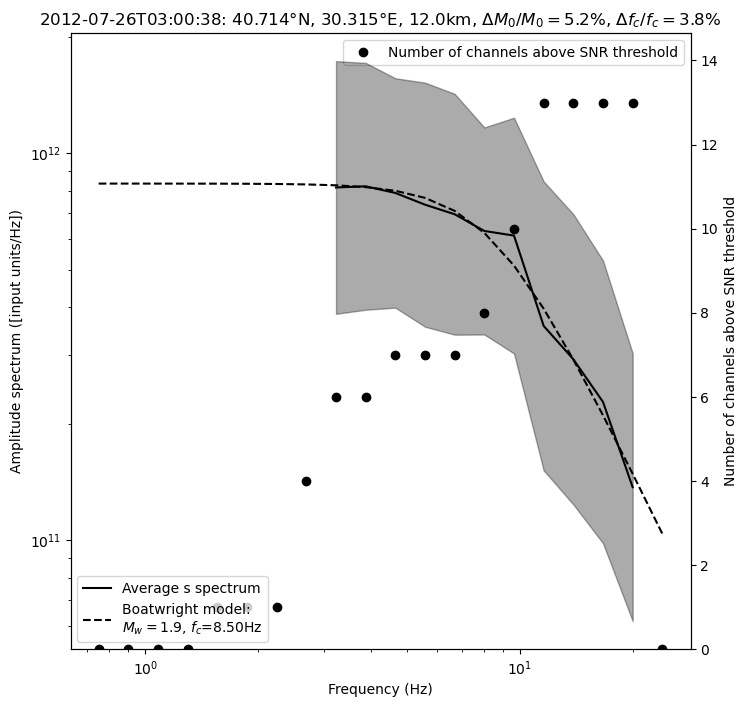

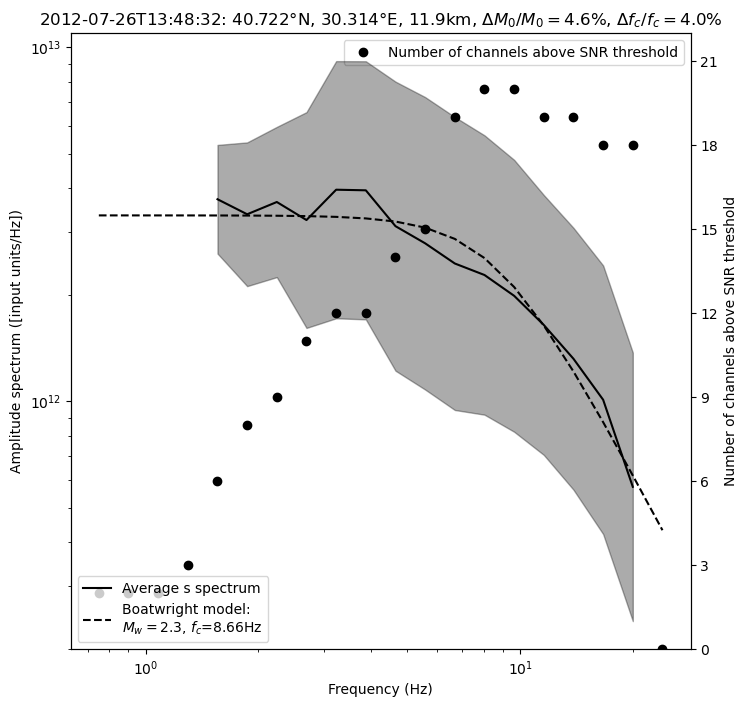

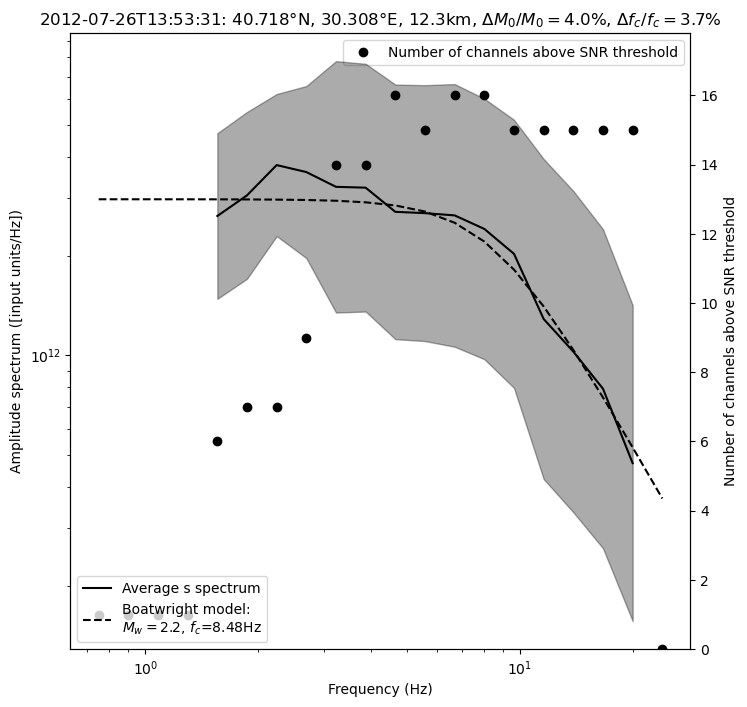

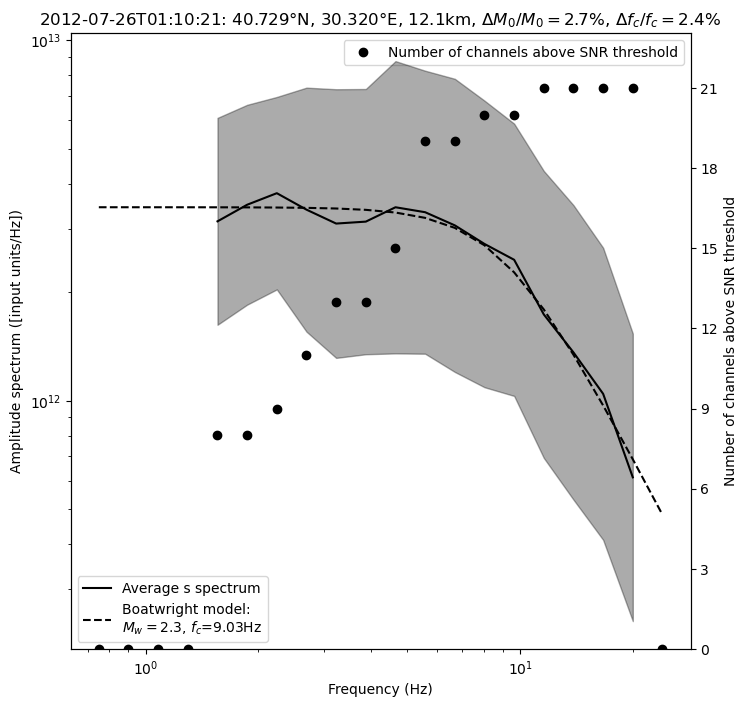

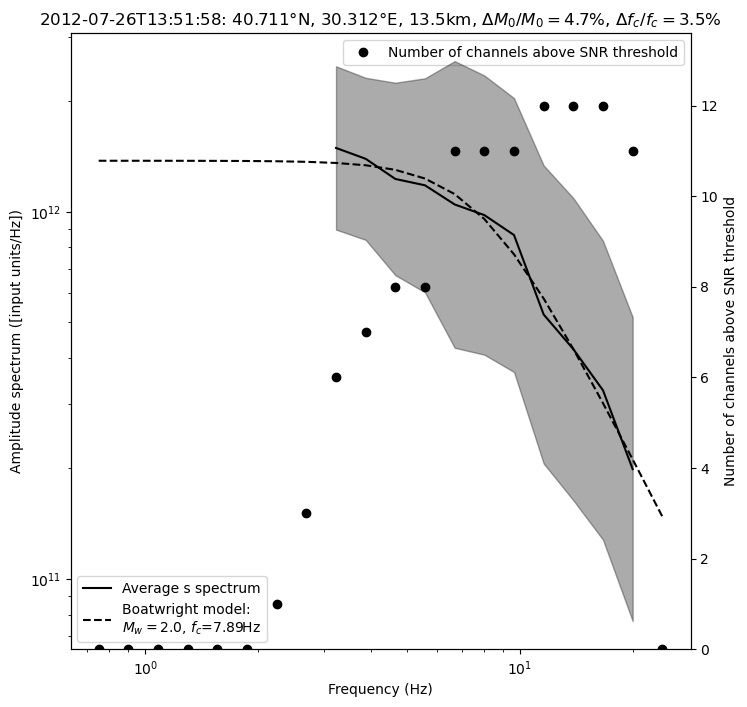

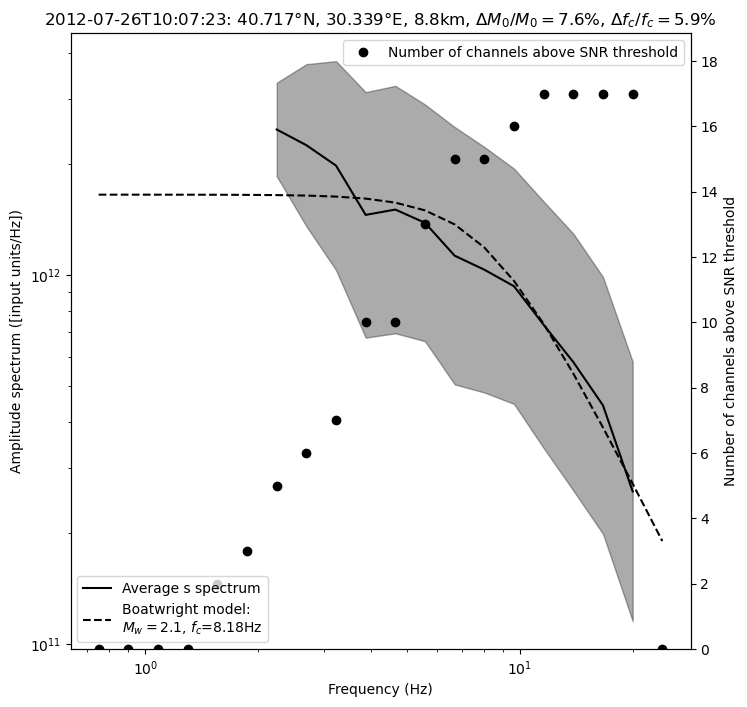

In [21]:

for i, event in enumerate(events):
    print("========================")
    print(f"Processing event {i}")
    #                 extract waveforms
    # first, read short extract before signal as an estimate of noise
    event.read_waveforms(
        DURATION_SEC,
        time_shifted=False,
        data_folder=DATA_FOLDER,
        offset_ot=OFFSET_OT_SEC_NOISE,
        attach_response=ATTACH_RESPONSE,
    )
    noise = event.traces.copy()

    # then, read signal
    event.read_waveforms(
        DURATION_SEC,
        phase_on_comp=PHASE_ON_COMP_P,
        offset_phase=OFFSET_PHASE,
        time_shifted=TIME_SHIFTED,
        data_folder=DATA_FOLDER,
        attach_response=ATTACH_RESPONSE,
    )
    event.zero_out_clipped_waveforms(kurtosis_threshold=-1)
    p_wave = event.traces.copy()


    event.read_waveforms(
        DURATION_SEC,
        phase_on_comp=PHASE_ON_COMP_S,
        offset_phase=OFFSET_PHASE,
        time_shifted=TIME_SHIFTED,
        data_folder=DATA_FOLDER,
        attach_response=ATTACH_RESPONSE,
    )
    event.zero_out_clipped_waveforms(kurtosis_threshold=-1)
    s_wave = event.traces.copy()

    # correct for instrument response and integrate to get displacement seismograms
    for st in [noise, p_wave, s_wave]:
        for tr in st:
            fnyq = tr.stats.sampling_rate / 2.
            pre_filt = [ 
                    1. / DURATION_SEC, 
                    1.05 / DURATION_SEC,
                    0.95 * fnyq,
                    0.98 * fnyq
                    ]
            tr.detrend("constant")
            tr.detrend("linear")
            tr.taper(0.25, type="cosine")
            tr.remove_response(
                pre_filt=pre_filt,
                zero_mean=False,
                taper=False,
                #taper_fraction=0.25,
                output="DISP",
                plot=False,
                    )

    # -----------------------------------------
    # now, compute multi-band displacement spectra
    # -----------------------------------------

    spectrum = BPMF.spectrum.Spectrum(event=event)
    spectrum.set_frequency_bands(FREQUENCY_BANDS)
    spectrum.compute_multi_band_spectrum(
        noise.select(component=USED_COMPONENTS), "noise", BUFFER_SEC,
        dev_mode=False
    )
    spectrum.compute_multi_band_spectrum(
        s_wave.select(component=USED_COMPONENTS), "s", BUFFER_SEC,
        dev_mode=False
    )
    spectrum.compute_multi_band_spectrum(
        p_wave.select(component=USED_COMPONENTS), "p", BUFFER_SEC,
        dev_mode=False
    )

    Q = Q_1HZ * np.power(spectrum.frequencies, N)
    spectrum.set_Q_model(Q, spectrum.frequencies)
    spectrum.compute_correction_factor(
        RHO_SOURCE_KGM3,
        RHO_RECEIVER_KGM3,
        VP_SOURCE_MS,
        VP_RECEIVER_MS,
        VS_SOURCE_MS,
        VS_RECEIVER_MS,
    )

    spectrum.set_target_frequencies(
        CENTER_FREQUENCIES[0],
        CENTER_FREQUENCIES[-1],
        NUM_FREQS
    )
    spectrum.resample(spectrum.frequencies, spectrum.phases)

    source_parameters = {}
    for phase_for_mag in ["s"]:
        spectrum.compute_signal_to_noise_ratio(phase_for_mag)
        spectrum.compute_network_average_spectrum(
            phase_for_mag,
            SNR_THRESHOLD,
            min_num_valid_channels_per_freq_bin=MIN_NUM_VALID_CHANNELS_PER_FREQ_BIN,
            max_relative_distance_err_pct=MAX_RELATIVE_DISTANCE_ERR_PCT,
        )
        if not phase_for_mag in spectrum.average_spectra:
            continue
        spectrum.fit_average_spectrum(
            phase_for_mag,
            model=SPECTRAL_MODEL,
            min_fraction_valid_points_below_fc=MIN_FRACTION_VALID_POINTS_BELOW_FC,
            weighted=NUM_CHANNEL_WEIGHTED_FIT,
        )
        if spectrum.inversion_success:
            rel_M0_err = 100.*spectrum.M0_err/spectrum.M0
            rel_fc_err = 100.*spectrum.fc_err/spectrum.fc
            if rel_M0_err > 10. or spectrum.fc < 0. or spectrum.fc > 25.:
                continue
            # event.set_aux_data({f"Mw_{phase_for_mag}": spectrum.Mw})
            figtitle = (f"{event.origin_time.strftime('%Y-%m-%dT%H:%M:%S')}: "
                        f"{event.latitude:.3f}""\u00b0"
                        f"N, {event.longitude:.3f}""\u00b0"
                        f"E, {event.depth:.1f}km, "
                        r"$\Delta M_0 / M_0=$"f"{rel_M0_err:.1f}%, "
                        r"$\Delta f_c / f_c=$"f"{rel_fc_err:.1f}%")
            source_parameters[f"M0_{phase_for_mag}"] = spectrum.M0
            source_parameters[f"Mw_{phase_for_mag}"] = spectrum.Mw
            source_parameters[f"fc_{phase_for_mag}"] = spectrum.fc
            source_parameters[f"M0_err_{phase_for_mag}"] = spectrum.M0_err
            source_parameters[f"fc_err_{phase_for_mag}"] = spectrum.fc_err
            fig = spectrum.plot_average_spectrum(
                    phase_for_mag,
                    plot_fit=True,
                    figname=f"{phase_for_mag}_spectrum_{event.id}",
                    figtitle=figtitle,
                    figsize=(8, 8),
                    plot_std=True,
                    plot_num_valid_channels=True,
                    )
            
    Mw_exists = False
    norm = 0.
    Mw = 0.
    Mw_err = 0.
    for ph in ["p", "s"]:
        if f"Mw_{ph}" in source_parameters:
            Mw += source_parameters[f"Mw_{ph}"]
            Mw_err += 2./3. * source_parameters[f"M0_err_{ph}"]/source_parameters[f"M0_{ph}"]
            norm += 1
            Mw_exists = True
    if Mw_exists:
        Mw /= norm
        Mw_err /= norm
        source_parameters["Mw"] = Mw
        source_parameters["Mw_err"] = Mw_err
    else:
        Mw = np.nan
        Mw_err = np.nan

    print(f"The P-S averaged moment magnitude is {Mw:.2f} +/- {Mw_err:.2f}")
    # save all this new information in BPMF.dataset.Event.aux_data
    event.set_aux_data(source_parameters)


### Estimate a moment magnitude for every event: Traditional method (un-comment if you want to run it)

In [22]:
#         waveform extraction parameters
# PHASE_ON_COMP: dictionary defining which moveout we use to extract the waveform
PHASE_ON_COMP_S = {"N": "S", "1": "S", "E": "S", "2": "S", "Z": "S"}
PHASE_ON_COMP_P = {"N": "P", "1": "P", "E": "P", "2": "P", "Z": "P"}

# BUFFER_SEC: duration, in sec, of time window taken before and after the window of interest
#             which we need to avoid propagating the pre-filtering taper operation into our
#             amplitude readings
BUFFER_SEC = 3.0
# OFFSET_PHASE: dictionary defining the time offset taken before a given phase
#               for example OFFSET_PHASE["P"] = 1.0 means that we extract the window
#               1 second before the predicted P arrival time
OFFSET_PHASE = {"P": 0.5 + BUFFER_SEC, "S": 0.5 + BUFFER_SEC}
DURATION_SEC = 3.0 + 2.0 * BUFFER_SEC
OFFSET_OT_SEC_NOISE = DURATION_SEC 

TIME_SHIFTED = True
DATA_FOLDER = "raw"
DATA_READER = data_reader_mseed
ATTACH_RESPONSE = True

#       spectral inversion parameters
SPECTRAL_MODEL = "boatwright"
RHO_SOURCE_KGM3 = 2700.0
VS_SOURCE_MS = 3500.0
VP_SOURCE_MS = VS_SOURCE_MS * 1.72
RHO_RECEIVER_KGM3 = 2600.0
VS_RECEIVER_MS = 2800.0
VP_RECEIVER_MS = VS_RECEIVER_MS * 1.72
FREQ_MIN_HZ = 0.5
FREQ_MAX_HZ = 20.
NUM_FREQS = 100
SNR_THRESHOLD = 10.
MIN_NUM_VALID_CHANNELS_PER_FREQ_BIN = 5
MIN_FRACTION_VALID_POINTS_BELOW_FC = 0.20
MAX_RELATIVE_DISTANCE_ERR_PCT = 33.
NUM_CHANNEL_WEIGHTED_FIT = True

#                   attenuation model
Q_1HZ = 33.
N = 0.75

Let's run the magnitude computation code for every event. If fitting the network-averaged displacement spectrum is not possible because of poor SNR or location, or if the inverted parameters' errors are too large then the moment magnitude cannot be estimated and the returned value is `nan`. 

In [23]:
for i, event in enumerate(events):
    print("========================")
    print(f"Processing event {i}")
    
    #                 extract waveforms
    # first, read short extract before signal as an estimate of noise
    event.read_waveforms(
        DURATION_SEC,
        time_shifted=False,
        data_folder=DATA_FOLDER,
        offset_ot=OFFSET_OT_SEC_NOISE,
        attach_response=ATTACH_RESPONSE,
    )
    noise = event.traces.copy()

    # then, read signal
    event.read_waveforms(
        DURATION_SEC,
        phase_on_comp=PHASE_ON_COMP_P,
        offset_phase=OFFSET_PHASE,
        time_shifted=TIME_SHIFTED,
        data_folder=DATA_FOLDER,
        attach_response=ATTACH_RESPONSE,
    )
    event.zero_out_clipped_waveforms(kurtosis_threshold=-1)
    p_wave = event.traces.copy()

    event.read_waveforms(
        DURATION_SEC,
        phase_on_comp=PHASE_ON_COMP_S,
        offset_phase=OFFSET_PHASE,
        time_shifted=TIME_SHIFTED,
        data_folder=DATA_FOLDER,
        attach_response=ATTACH_RESPONSE,
    )
    event.zero_out_clipped_waveforms(kurtosis_threshold=-1)
    s_wave = event.traces.copy()

    # correct for instrument response and integrate to get displacement seismograms
    for st in [noise, p_wave, s_wave]:
        for tr in st:
            fnyq = tr.stats.sampling_rate / 2.
            pre_filt = [ 
                    1. / DURATION_SEC, 
                    1.05 / DURATION_SEC,
                    0.95 * fnyq,
                    0.98 * fnyq
                    ]
            tr.detrend("constant")
            tr.detrend("linear")
            tr.taper(0.25, type="cosine")
            tr.remove_response(
                pre_filt=pre_filt,
                zero_mean=False,
                taper=False,
                #taper_fraction=0.25,
                output="DISP",
                plot=False,
                    )
            tr.trim(
                    starttime=tr.stats.starttime + BUFFER_SEC,
                    endtime=tr.stats.endtime - BUFFER_SEC
                    )
    
    spectrum = BPMF.spectrum.Spectrum(event=event)
    spectrum.compute_spectrum(noise, "noise")
    spectrum.compute_spectrum(p_wave, "p")
    spectrum.compute_spectrum(s_wave, "s")

    spectrum.set_target_frequencies(FREQ_MIN_HZ, FREQ_MAX_HZ, NUM_FREQS)
    spectrum.resample(spectrum.frequencies, spectrum.phases)
    spectrum.compute_signal_to_noise_ratio("p")
    spectrum.compute_signal_to_noise_ratio("s")

    Q = Q_1HZ * np.power(spectrum.frequencies, N)
    spectrum.set_Q_model(Q, spectrum.frequencies)
    spectrum.compute_correction_factor(
        RHO_SOURCE_KGM3, RHO_RECEIVER_KGM3,
        VP_SOURCE_MS, VP_RECEIVER_MS,
        VS_SOURCE_MS, VS_RECEIVER_MS
    )

    source_parameters = {}
    for phase_for_mag in ["s"]:
        spectrum.compute_network_average_spectrum(
            phase_for_mag,
            SNR_THRESHOLD,
            min_num_valid_channels_per_freq_bin=MIN_NUM_VALID_CHANNELS_PER_FREQ_BIN,
            max_relative_distance_err_pct=MAX_RELATIVE_DISTANCE_ERR_PCT
            )
        if not phase_for_mag in spectrum.average_spectra:
            continue
        spectrum.integrate(phase_for_mag, average=True)
        spectrum.fit_average_spectrum(
                phase_for_mag,
                model=SPECTRAL_MODEL,
                min_fraction_valid_points_below_fc=MIN_FRACTION_VALID_POINTS_BELOW_FC,
                weighted=NUM_CHANNEL_WEIGHTED_FIT
                )
        if spectrum.inversion_success:
            rel_M0_err = 100.*spectrum.M0_err/spectrum.M0
            rel_fc_err = 100.*spectrum.fc_err/spectrum.fc
            if rel_M0_err > 10. or spectrum.fc < 0. or spectrum.fc > 25.:
                continue
            # event.set_aux_data({f"Mw_{phase_for_mag}": spectrum.Mw})
            figtitle = (f"{event.origin_time.strftime('%Y-%m-%dT%H:%M:%S')}: "
                        f"{event.latitude:.3f}""\u00b0"
                        f"N, {event.longitude:.3f}""\u00b0"
                        f"E, {event.depth:.1f}km, "
                        r"$\Delta M_0 / M_0=$"f"{rel_M0_err:.1f}%, "
                        r"$\Delta f_c / f_c=$"f"{rel_fc_err:.1f}%")
            source_parameters[f"M0_{phase_for_mag}"] = spectrum.M0
            source_parameters[f"Mw_{phase_for_mag}"] = spectrum.Mw
            source_parameters[f"fc_{phase_for_mag}"] = spectrum.fc
            source_parameters[f"M0_err_{phase_for_mag}"] = spectrum.M0_err
            source_parameters[f"fc_err_{phase_for_mag}"] = spectrum.fc_err
            fig = spectrum.plot_average_spectrum(
                    phase_for_mag,
                    plot_fit=True,
                    figname=f"{phase_for_mag}_spectrum_{i}",
                    figtitle=figtitle,
                    figsize=(8, 8),
                    plot_std=True,
                    plot_num_valid_channels=True,
                    )

    Mw_exists = False
    norm = 0.
    Mw = 0.
    Mw_err = 0.
    for ph in ["p", "s"]:
        if f"Mw_{ph}" in source_parameters:
            Mw += source_parameters[f"Mw_{ph}"]
            Mw_err += 2./3. * source_parameters[f"M0_err_{ph}"]/source_parameters[f"M0_{ph}"]
            norm += 1
            Mw_exists = True
    if Mw_exists:
        Mw /= norm
        Mw_err /= norm
        source_parameters["Mw"] = Mw
        source_parameters["Mw_err"] = Mw_err
    else:
        Mw = np.nan
        Mw_err = np.nan

    print(f"The P-S averaged moment magnitude is {Mw:.2f} +/- {Mw_err:.2f}")
    source_parameters["Mw"] = Mw
    source_parameters["Mw_err"] = Mw_err
    
    # save all this new information in BPMF.dataset.Event.aux_data
    event.set_aux_data(source_parameters)


Processing event 0
The P-S averaged moment magnitude is nan +/- nan
Processing event 1
The P-S averaged moment magnitude is nan +/- nan
Processing event 2
The P-S averaged moment magnitude is nan +/- nan
Processing event 3
The P-S averaged moment magnitude is nan +/- nan
Processing event 4
The P-S averaged moment magnitude is nan +/- nan
Processing event 5
The P-S averaged moment magnitude is nan +/- nan
Processing event 6
Not enough valid points! (Only 9.00%)
The P-S averaged moment magnitude is nan +/- nan
Processing event 7
The P-S averaged moment magnitude is nan +/- nan
Processing event 8
The P-S averaged moment magnitude is nan +/- nan
Processing event 9
Not enough valid points below corner frequency (only 7.0%)
The P-S averaged moment magnitude is nan +/- nan
Processing event 10
The P-S averaged moment magnitude is nan +/- nan
Processing event 11
Not enough valid points below corner frequency (only 0.0%)
The P-S averaged moment magnitude is nan +/- nan
Processing event 12
The P-

## Approximate moment magnitude estimation

To compute the approximate moment magnitude $M_{w^*}$ of an event, as we defined at the beginning of this notebook, we actually just need to add a block of code in the same processing that we used to estimate moment magnitudes. Thus, it usually makes sense to compute both at the same time. While most events do not produce a valid moment magnitude estimate, we get an approximate moment magnitude for each event.

In [24]:

#         waveform extraction parameters
# PHASE_ON_COMP: dictionary defining which moveout we use to extract the waveform
PHASE_ON_COMP_S = {"N": "S", "1": "S", "E": "S", "2": "S", "Z": "S"}
PHASE_ON_COMP_P = {"N": "P", "1": "P", "E": "P", "2": "P", "Z": "P"}
# BUFFER_SEC: duration, in sec, of time window taken before and after the window of interest
#             which we need to avoid propagating the pre-filtering taper operation into our
#             amplitude readings
BUFFER_SEC = 6.0
# OFFSET_PHASE: dictionary defining the time offset taken before a given phase
#               for example OFFSET_PHASE["P"] = 1.0 means that we extract the window
#               1 second before the predicted P arrival time
OFFSET_PHASE = {"P": 0.5 + BUFFER_SEC, "S": 0.5 + BUFFER_SEC}
DURATION_SEC = 3.0 + 2.0 * BUFFER_SEC
OFFSET_OT_SEC_NOISE = DURATION_SEC 
TIME_SHIFTED = True
DATA_FOLDER = "raw"
DATA_READER = data_reader_mseed
ATTACH_RESPONSE = True

#       multi-band-filtering parameters
FREQUENCY_BANDS = {
    "0.5Hz-1.0Hz": [0.5, 1.0],
    "1.0Hz-2.0Hz": [1.0, 2.0],
    "2.0Hz-4.0Hz": [2.0, 4.0],
    "4.0Hz-8.0Hz": [4.0, 8.0],
    "8.0Hz-16.0Hz": [8.0, 16.0],
    "16.0Hz-32.0Hz": [16.0, 32.0],
}
FILTER_ORDER = 4
USED_COMPONENTS = "[N,E,1,2,Z]"
CENTER_FREQUENCIES = [
    0.5
    * (
        FREQUENCY_BANDS[band][0] + FREQUENCY_BANDS[band][1]
    )
    for band in FREQUENCY_BANDS
]

#       spectral inversion parameters
SPECTRAL_MODEL = "boatwright"
RHO_SOURCE_KGM3 = 2700.0
VS_SOURCE_MS = 3500.0
VP_SOURCE_MS = VS_SOURCE_MS * 1.72
RHO_RECEIVER_KGM3 = 2600.0
VS_RECEIVER_MS = 2800.0
VP_RECEIVER_MS = VS_RECEIVER_MS * 1.72

NUM_FREQS = 20
SNR_THRESHOLD = 10.
MIN_NUM_VALID_CHANNELS_PER_FREQ_BIN = 5
MIN_FRACTION_VALID_POINTS_BELOW_FC = 0.20
MAX_RELATIVE_DISTANCE_ERR_PCT = 33.
NUM_CHANNEL_WEIGHTED_FIT = True


PHASE_FOR_MAG = "s"
NUM_AVERAGING_BANDS = 3
LOW_SNR_FREQ_MIN_HZ = 2.0
A_MOMENT_MAGNITUDE_SCALING = 2. /3.
B_MOMENT_MAGNITUDE_SCALING = -9.1 * A_MOMENT_MAGNITUDE_SCALING

#       attenuation model
Q_1HZ = 33.
N = 0.75

In [25]:
def snr_based_weights(snr, snr_threshold, weight_max=3.0, max_num_bad_measurements=9):
    # allow some numerical noise (?)
    snr_clipped = np.minimum(snr, 1.001 * snr_threshold)
    # linear function of snr
    weights = snr_clipped
    # clip weights
    weights = np.minimum(weights, weight_max)
    if np.sum(snr >= snr_threshold) >= max_num_bad_measurements:
        # set weights of bad measurements to 0
        weights[snr < snr_threshold] = 0.
    else:
        ordered_indexes = np.argsort(snr)
        # set to 0 all but the `max_num_bad_measurements` least bad meas.
        weights[ordered_indexes[:-max_num_bad_measurements]] = 0.
    return weights


Processing event 0
The P-S averaged moment magnitude is nan +/- nan and the local magnitude is 1.21
Processing event 1
The P-S averaged moment magnitude is nan +/- nan and the local magnitude is 1.35
Processing event 2
The P-S averaged moment magnitude is nan +/- nan and the local magnitude is 1.17
Processing event 3
The P-S averaged moment magnitude is nan +/- nan and the local magnitude is 1.34
Processing event 4
The P-S averaged moment magnitude is nan +/- nan and the local magnitude is 1.25
Processing event 5
The P-S averaged moment magnitude is nan +/- nan and the local magnitude is 1.28
Processing event 6
The P-S averaged moment magnitude is 1.88 +/- 0.03 and the local magnitude is 1.66
Processing event 7
The P-S averaged moment magnitude is nan +/- nan and the local magnitude is 1.33
Processing event 8
The P-S averaged moment magnitude is nan +/- nan and the local magnitude is 1.36
Processing event 9
The P-S averaged moment magnitude is 2.28 +/- 0.03 and the local magnitude is 2

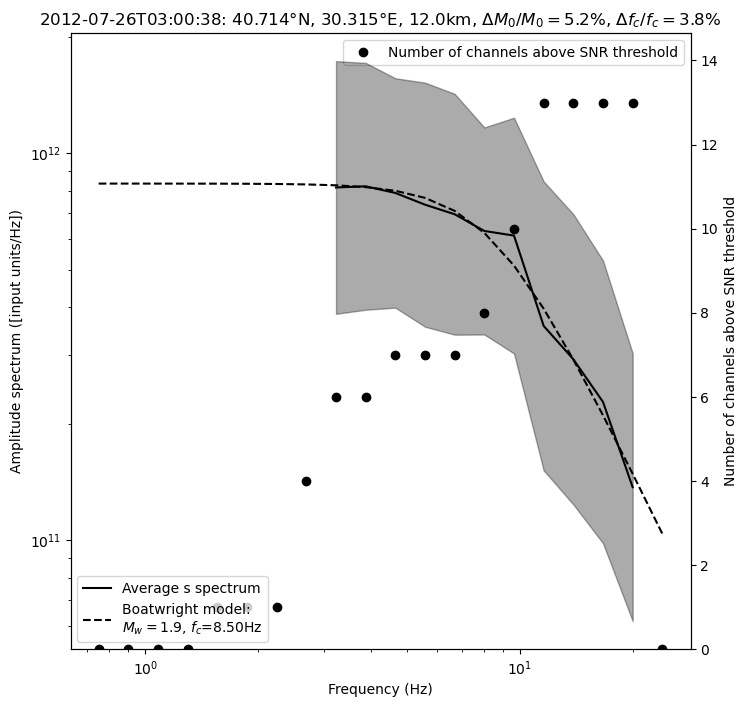

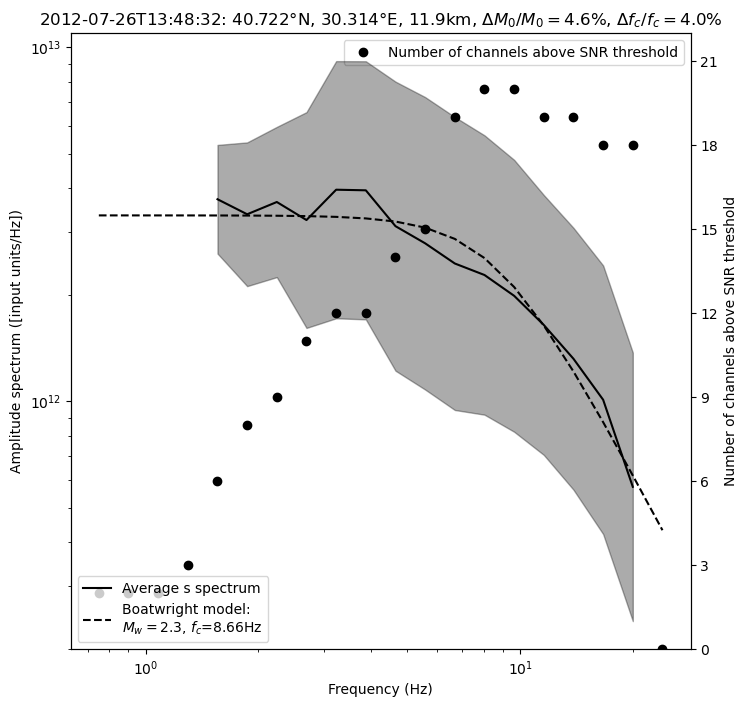

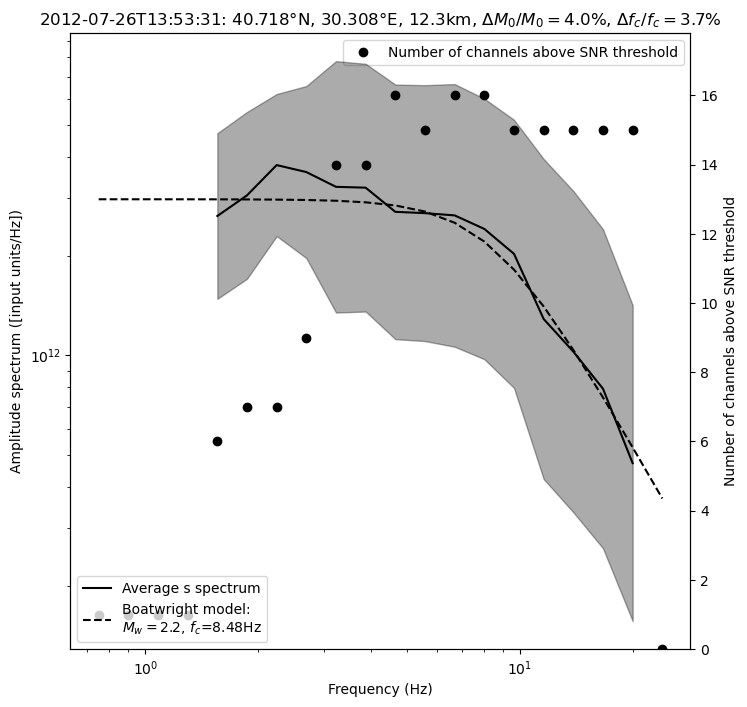

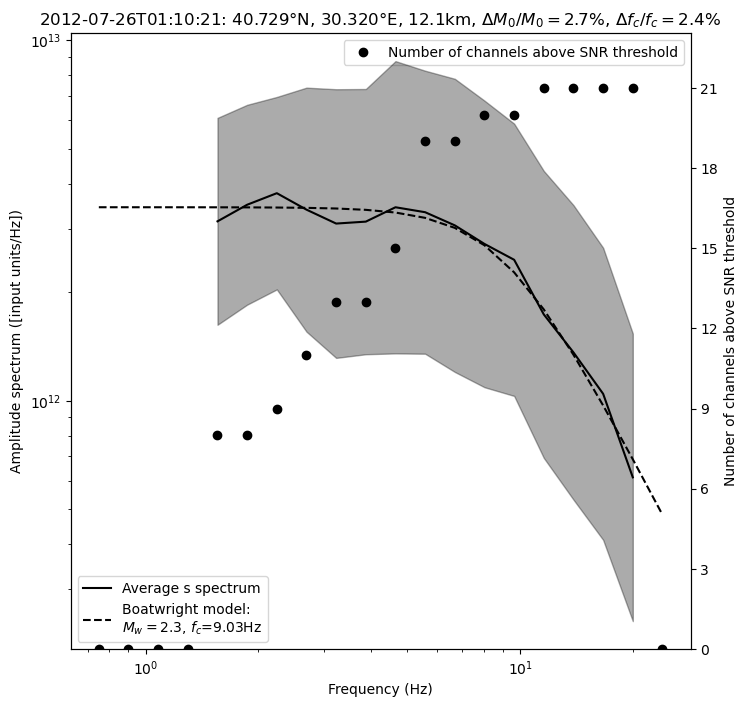

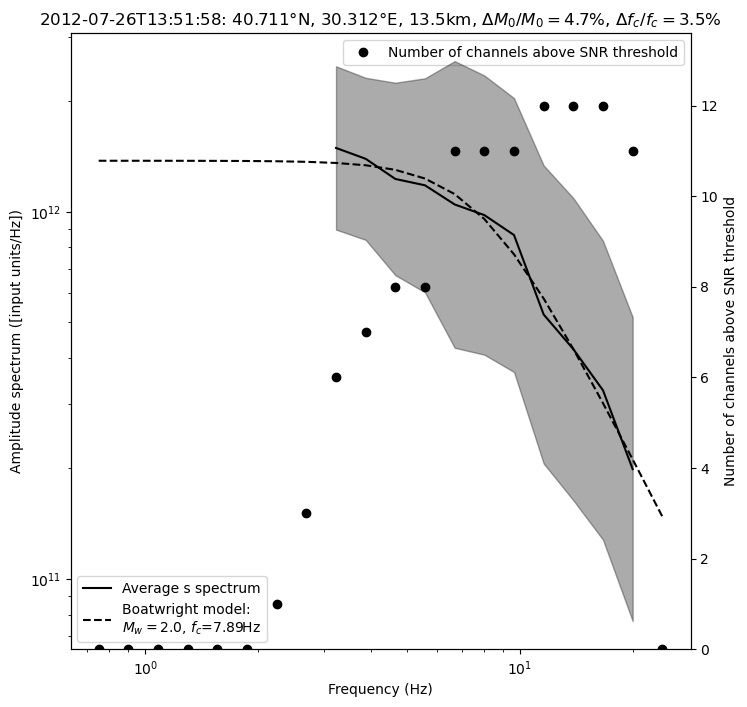

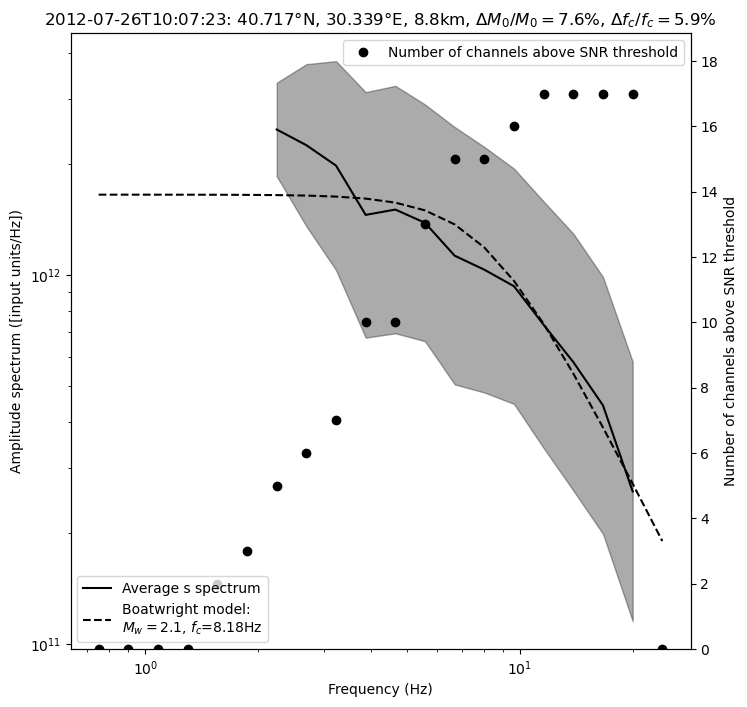

In [26]:
for i, event in enumerate(events):
    print("========================")
    print(f"Processing event {i}")
    source_parameters = {}
    #                 extract waveforms
    # first, read short extract before signal as an estimate of noise
    event.read_waveforms(
        DURATION_SEC,
        time_shifted=False,
        data_folder=DATA_FOLDER,
        offset_ot=OFFSET_OT_SEC_NOISE,
        attach_response=ATTACH_RESPONSE,
    )
    noise = event.traces.copy()

    event.read_waveforms(
        DURATION_SEC,
        phase_on_comp=PHASE_ON_COMP_S,
        offset_phase=OFFSET_PHASE,
        time_shifted=TIME_SHIFTED,
        data_folder=DATA_FOLDER,
        attach_response=ATTACH_RESPONSE,
    )
    event.zero_out_clipped_waveforms(kurtosis_threshold=-1)
    s_wave = event.traces.copy()

    # correct for instrument response and integrate to get displacement seismograms
    for st in [noise, s_wave]:
        for tr in st:
            fnyq = tr.stats.sampling_rate / 2.
            pre_filt = [ 
                    1. / DURATION_SEC, 
                    1.05 / DURATION_SEC,
                    0.95 * fnyq,
                    0.98 * fnyq
                    ]
            tr.detrend("constant")
            tr.detrend("linear")
            tr.taper(0.25, type="cosine")
            tr.remove_response(
                pre_filt=pre_filt,
                zero_mean=False,
                taper=False,
                #taper_fraction=0.25,
                output="DISP",
                plot=False,
                    )

    # -----------------------------------------
    # now, compute multi-band displacement spectra
    # -----------------------------------------
    spectrum = BPMF.spectrum.Spectrum(event=event)
    spectrum.set_frequency_bands(FREQUENCY_BANDS)
    spectrum.compute_multi_band_spectrum(
        noise.select(component=USED_COMPONENTS), "noise", BUFFER_SEC,
        dev_mode=False
    )
    spectrum.compute_multi_band_spectrum(
        s_wave.select(component=USED_COMPONENTS), "s", BUFFER_SEC,
        dev_mode=False
    )

    Q = Q_1HZ * np.power(spectrum.frequencies, N)
    spectrum.set_Q_model(Q, spectrum.frequencies)
    spectrum.compute_correction_factor(
        RHO_SOURCE_KGM3,
        RHO_RECEIVER_KGM3,
        VP_SOURCE_MS,
        VP_RECEIVER_MS,
        VS_SOURCE_MS,
        VS_RECEIVER_MS,
    )

    # -----------------------------------------------------
    #        measurement for local magnitude
    # -----------------------------------------------------
    spectrum.compute_signal_to_noise_ratio(PHASE_FOR_MAG)
    
    if len(spectrum.s_spectrum) == 0:
        print(f"Could not compute a single spectrum!")
        source_parameters["Me"] = np.nan
        source_parameters["Mw"] = np.nan
        source_parameters["Mw_err"] = np.nan
        source_parameters["Ml"] = np.nan
        print(f"The P-S averaged moment magnitude {np.nan} +/- {np.nan}")
        # save all this new information in BPMF.dataset.Event.aux_data
        event.set_aux_data(source_parameters)
        continue

    # store multi-band, geometrical-spreading-corrected displacement
    # spectra in a pandas.DataFrame
    # 1) fetch raw displacement spectra
    s_spectra = pd.DataFrame(
        columns=list(spectrum.s_spectrum.keys()),
        #index=list(FREQUENCY_BANDS.keys()),
        index=CENTER_FREQUENCIES,
        data=np.stack(
            [spectrum.s_spectrum[trid]["spectrum"] for trid in spectrum.s_spectrum],
            axis=1,
        ),
    )
    # 2) apply geometrical spreading correction
    for trid in s_spectra.columns:
        station = trid.split(".")[1]
        s_spectra.loc[:, trid] *= spectrum.correction_factor.loc[
            station, "correction_S"
        ]
    # 3) apply attenuation correction?
    for trid in s_spectra.columns:
        station = trid.split(".")[1]
        s_spectra.loc[:, trid] *= spectrum.attenuation_factor.loc[
            station, "attenuation_S"
        ]
    # store snr in a pandas.DataFrame
    snr_spectra = pd.DataFrame(
        columns=list(spectrum.snr_s_spectrum.keys()),
        #index=list(FREQUENCY_BANDS.keys()),
        index=CENTER_FREQUENCIES,
        data=np.stack(
            [spectrum.snr_s_spectrum[trid]["snr"] for trid in spectrum.snr_s_spectrum],
            axis=1,
        ),
    )

    geo_corrected_peaks = pd.Series(index=list(s_spectra.columns), dtype=np.float32)
    num_cha = len(s_spectra.columns)
    #weights = np.zeros(num_cha, dtype=np.float32)
    _snr = np.zeros(num_cha, dtype=np.float32)
    #try:
    for j, idx in enumerate(geo_corrected_peaks.index):
        station = idx.split(".")[1]
        multi_band_peaks = s_spectra.loc[:, idx]
        multi_band_snr = snr_spectra.loc[:, idx]
        valid_bands = multi_band_snr.loc[
                multi_band_snr > SNR_THRESHOLD
                ].index
        if len(valid_bands) > 0:
            # peak amplitude is taken from the lowest-frequency,
            # valid frequency band (reflect physical seismic moment)
            valid_bands = np.sort(valid_bands)
            selected_bands = valid_bands[
                    :min(len(valid_bands), NUM_AVERAGING_BANDS)
                    ]
            if len(selected_bands) > 1:
                geo_corrected_peaks.loc[idx] = np.median(
                        multi_band_peaks.loc[selected_bands].values
                        )
            else:
                geo_corrected_peaks.loc[idx] = multi_band_peaks.loc[
                        selected_bands
                        ].values[0]
            _snr[j] = SNR_THRESHOLD
        else:
            # peak amplitude is taken from the highest snr frequency
            # band (implies error on magnitude estimation)
            high_freq = multi_band_snr.index > LOW_SNR_FREQ_MIN_HZ
            freq_idx = multi_band_snr[high_freq].index[
                    multi_band_snr[high_freq].argmax()
                    ]
            w_ = multi_band_snr.loc[high_freq]
            p_ = multi_band_peaks.loc[high_freq]
            sum_ = w_.sum()
            sum_ = 1. if sum_ == 0. else sum_
            geo_corrected_peaks.loc[idx] = (w_ * p_).sum() / sum_
            _snr[j] = (w_ * multi_band_snr.loc[high_freq]).sum() / sum_

    _snr[geo_corrected_peaks == 0.] = 0.
    weights = snr_based_weights(_snr, SNR_THRESHOLD)

    weighted_log_peaks = np.zeros(len(weights), dtype=np.float64)
    weighted_log_peaks[weights > 0.] = (
            np.log10(geo_corrected_peaks[weights > 0.]) * weights[weights > 0.]
            )
    estimated_log10_M0 = weighted_log_peaks.sum() / weights.sum()
    Mw_approx = (
        A_MOMENT_MAGNITUDE_SCALING * estimated_log10_M0
        + B_MOMENT_MAGNITUDE_SCALING
    )
    source_parameters["Mw*"] = Mw_approx

    spectrum.set_target_frequencies(
        CENTER_FREQUENCIES[0],
        CENTER_FREQUENCIES[-1],
        NUM_FREQS
    )
    spectrum.resample(spectrum.frequencies, spectrum.phases)

    spectrum.compute_signal_to_noise_ratio(PHASE_FOR_MAG)
    spectrum.compute_network_average_spectrum(
        PHASE_FOR_MAG,
        SNR_THRESHOLD,
        min_num_valid_channels_per_freq_bin=MIN_NUM_VALID_CHANNELS_PER_FREQ_BIN,
        max_relative_distance_err_pct=MAX_RELATIVE_DISTANCE_ERR_PCT,
    )
    if PHASE_FOR_MAG in spectrum.average_spectra:
        spectrum.fit_average_spectrum(
            PHASE_FOR_MAG,
            model=SPECTRAL_MODEL,
            min_fraction_valid_points_below_fc=MIN_FRACTION_VALID_POINTS_BELOW_FC,
            weighted=NUM_CHANNEL_WEIGHTED_FIT,
        )
    if hasattr(spectrum, "inversion_success") and spectrum.inversion_success:
        rel_M0_err = 100.*spectrum.M0_err/spectrum.M0
        rel_fc_err = 100.*spectrum.fc_err/spectrum.fc
        if not (rel_M0_err > 10. or spectrum.fc < 0.):
            figtitle = (f"{event.origin_time.strftime('%Y-%m-%dT%H:%M:%S')}: "
                        f"{event.latitude:.3f}""\u00b0"
                        f"N, {event.longitude:.3f}""\u00b0"
                        f"E, {event.depth:.1f}km, "
                        r"$\Delta M_0 / M_0=$"f"{rel_M0_err:.1f}%, "
                        r"$\Delta f_c / f_c=$"f"{rel_fc_err:.1f}%")
            source_parameters[f"M0_{PHASE_FOR_MAG}"] = spectrum.M0
            source_parameters[f"Mw_{PHASE_FOR_MAG}"] = spectrum.Mw
            source_parameters[f"fc_{PHASE_FOR_MAG}"] = spectrum.fc
            source_parameters[f"M0_err_{PHASE_FOR_MAG}"] = spectrum.M0_err
            source_parameters[f"fc_err_{PHASE_FOR_MAG}"] = spectrum.fc_err
            fig = spectrum.plot_average_spectrum(
                    PHASE_FOR_MAG,
                    plot_fit=True,
                    figname=f"{PHASE_FOR_MAG}_spectrum_{event.id}",
                    figtitle=figtitle,
                    figsize=(8, 8),
                    plot_std=True,
                    plot_num_valid_channels=True,
                    )
            
    Mw_exists = False
    norm = 0.
    Mw = 0.
    Mw_err = 0.
    for ph in ["p", "s"]:
        if f"Mw_{ph}" in source_parameters:
            Mw += source_parameters[f"Mw_{ph}"]
            Mw_err += 2./3. * source_parameters[f"M0_err_{ph}"]/source_parameters[f"M0_{ph}"]
            norm += 1
            Mw_exists = True
    if Mw_exists:
        Mw /= norm
        Mw_err /= norm
        source_parameters["Mw"] = Mw
        source_parameters["Mw_err"] = Mw_err
    else:
        Mw = np.nan
        Mw_err = np.nan

    print(
        f"The P-S averaged moment magnitude is {Mw:.2f} +/- {Mw_err:.2f} "
        f"and the local magnitude is {Mw_approx:.2f}"
        )
    # save all this new information in BPMF.dataset.Event.aux_data
    event.set_aux_data(source_parameters)


In [27]:
magnitudes = {
    "Mw": [ev.aux_data["Mw"] for ev in events],
    "Mw*": [ev.aux_data["Mw*"] for ev in events],
    "event_id": [ev.id for ev in events]
}
magnitudes = pd.DataFrame(magnitudes)
magnitudes.set_index("event_id", inplace=True)
magnitudes

,Mw,Mw*
event_id,,
20120726_005816.160000,NaN,1.207162
20120726_011629.640000,NaN,1.350513
20120726_011832.520000,NaN,1.165677
20120726_014730.080000,NaN,1.342158
20120726_022249.440000,NaN,1.245946
20120726_010252.920000,NaN,1.282594
20120726_030038.720000,1.880766,1.659528
20120726_033250.800000,NaN,1.333005
20120726_033813.200000,NaN,1.357563


## Magnitude distribution

Let's now have a look at the distribution of earthquake magnitudes. We provide a few functions for building, modeling and plotting the distribution.

In [28]:
def fM_distribution(M, Mmin=-1.0, Mmax=4.0, nbins=30, null_value=-10):
    """
    Parameters
    ----------
    M: numpy.ndarray
        Magnitudes.
    Mmin: scalar float, optional
        Minimum magnitude in histogram. Default to -1.
    Mmax: scalar float, optional
        Maximum magnitude in histogram. Default to 4.
    nbins: scalar int, optional
        Number of bins in histogram. Default to 30.
    null_value: scalar int or float, optional
        Value indicating no data. Default to -10.

    Returns
    -------
    count: numpy.ndarray
        Number of earthquakes per magnitude bin.
    cumulative_count: numpy.ndarray
        
    """
    count, bins = np.histogram(
        M[M != null_value],
        range=(Mmin, Mmax),
        bins=nbins,
    )
    mag_bins = (bins[1:] + bins[:-1]) / 2.0
    # compute the cumulative magnitude distribution such that:
    # f(M) = n >= M
    count_for_descending_mag = count[::-1]
    cumulative_count = np.cumsum(count_for_descending_mag)
    # cumulative_count is given for descending magnitudes
    # reverse its order to get it for ascending magnitudes
    cumulative_count = cumulative_count[::-1]
    return count, cumulative_count, mag_bins


def MLE_bvalue(
        magnitudes,
        Mmax_fit=5.0,
        Mmin=-1.0,
        Mmax=4.0,
        nbins=30,
        null_value=-10,
        n_total_min=20,
        n_above_Mc_min=10,
        Mc_buffer=0.2
        ):
    """
    Maximum Likelihood Estimate of the b-value.

    Parameters
    ----------
    magnitudes : numpy.ndarray
        Magnitudes.
    Mmax_fit : float, optional
        Maximum magnitude included in the estimation of the b-value. Default is 5.0.
    Mmin : float, optional
        Minimum magnitude in histogram. Default is -1.0.
    Mmax : float, optional
        Maximum magnitude in histogram. Default is 4.0.
    nbins : int, optional
        Number of bins in histogram. Default is 30.
    null_value : int or float, optional
        Value indicating no data. Default is -10.
    n_total_min : int, optional
        Minimum number of magnitudes to estimate the b-value. Default is 50.
    n_above_Mc_min : int, optional
        Minimum number of magnitudes above the magnitude of completeness. Default is 30.
    Mc_buffer : float, optional
        Magnitude interval added to the estimated Mc, magnitude of completeness,
        to increase the robustness of the estimation of b-value. Default is 0.2.
    Returns
    -------
    GR : dict
        A dictionary containing the following keys:

        cumulative_count : numpy.ndarray
            Cumulative number of earthquakes.
        magnitude_bins : numpy.ndarray
            Magnitude bins.
        magnitudes : numpy.ndarray
            Magnitudes.
        Mc : float
            Magnitude of completeness.
        b : float
            b-value of the Gutenberg-Richter distribution.
        a : float
            a-value of the Gutenberg-Richter distribution.
        b_err : float
            Error in the b-value estimation using Shi's method.
        a_err : float
            Error in the a-value estimation.
        kde : scipy.stats.gaussian_kde
            Gaussian kernel density estimate of the magnitude distribution.
        Mmin : float
            Minimum magnitude used in the histogram.
        Mmax : float
            Maximum magnitude used in the histogram.

    Raises
    ------
    Exception
        If there is an error in the estimation of the magnitude of
        completeness using the kernel density estimate.

    Notes
    -----
    The b-value of the Gutenberg-Richter distribution is estimated using the
    Maximum Likelihood Estimate (MLE) method [1]_. The a-value is estimated
    using the method of descending order statistics [2]_.
    
    References
    ----------
    .. [1] Aki, K. (1965). Maximum likelihood estimate of b in the formula
    log N = a − bM and its confidence limits. Bulletin of the Earthquake Research
    Institute, 43, 237-239.
    .. [2] Kanamori, H. (1977). The energy release in great earthquakes.
    Journal of Geophysical Research: Solid Earth, 82(20), 2981-2987.
    """
    from scipy.stats import gaussian_kde
    # remove null values
    magnitudes = magnitudes[magnitudes != null_value]
    count, cumulative_count, magnitude_bins = fM_distribution(
            magnitudes, Mmin=Mmin, Mmax=Mmax, nbins=nbins, null_value=null_value
            )
    # estimate pdf with gaussian kernels
    # apply the maximum curvature method to the
    # kde instead of the raw histogram
    try:
        kernel = gaussian_kde(magnitudes, bw_method=0.05)
        M_ = np.linspace(Mmin, Mmax, nbins)
        Mc = M_[kernel(M_).argmax()]  # + 0.2
    except Exception as e:
        print(e)
        Mc = magnitude_bins[count.argmax()]  # MAXC method
        kernel = None
    Mc_w_buffer = Mc + Mc_buffer
    bin0 = np.where(magnitude_bins >= Mc_w_buffer)[0][0]
    Mmax_fit = magnitudes.max()
    m_above_Mc = magnitudes[magnitudes >= Mc_w_buffer]
    n_total_mag = len(magnitudes)
    if len(m_above_Mc) > n_above_Mc_min and n_total_mag > n_total_min:
        # MLE b-value (Aki)
        b = 1.0 / (np.log(10) * np.mean(m_above_Mc - Mc_w_buffer))
        # Shi std err
        b_err = (
            2.3
            * b**2
            * np.sqrt(
                np.mean((m_above_Mc - np.mean(m_above_Mc)) ** 2)
                / (len(m_above_Mc) - 1.0)
            )
        )
        #bin0 = np.where(magnitude_bins >= Mc)[0][0]
        #a = np.log10(cumulative_count[bin0]) + b * magnitude_bins[bin0]
        descending_mag = np.sort(m_above_Mc)
        cum_count = np.arange(1, 1 + len(m_above_Mc))
        a = np.mean(np.log10(cum_count) + b*descending_mag)
        a_err = np.std(np.log10(cum_count) + b*descending_mag)
    else:
        a, a_err, b, b_err, Mc = 5*[null_value]
    # store everything in a dictionary
    GR = {
        "cumulative_count": cumulative_count,
        "magnitude_bins": magnitude_bins,
        "magnitudes": magnitudes,
        "Mc": Mc,
        "b": b,
        "a": a,
        "b_err": b_err,
        "a_err": a_err,
        "kde": kernel,
        "Mmin": Mmin, # for plot_bvalue
        "Mmax": Mmax, # for plot_bvalue
    }
    return GR

def plot_bvalue(GR, Mmin=None, Mmax=None, color="k", ax=None):
    """
    Plot the frequency-magnitude distribution and the b-value fit for a given
    Gutenberg-Richter relationship.

    Parameters
    ----------
    GR : dict
        A dictionary containing the Gutenberg-Richter relationship parameters.
        The dictionary must have the following keys:

        - "magnitude_bins" : 1D array
            Magnitude bins.
        - "cumulative_count" : 1D array
            Cumulative count of earthquakes with magnitude greater than or equal
            to the corresponding magnitude bin.
        - "magnitudes" : 1D array
            Magnitudes of all earthquakes.
        - "Mc" : float
            Magnitude of completeness.
        - "a" : float
            Intercept of the Gutenberg-Richter relationship.
        - "b" : float
            Slope of the Gutenberg-Richter relationship.
        - "b_err" : float
            Standard error of the b-value estimate.
        - "kde" : scipy.interpolate.interp1d object
            Kernel density estimate of the magnitude distribution.

    Mmin : float, optional
        Minimum magnitude to consider in the distribution. If not given, it
        defaults to GR["Mmin"].
    Mmax : float, optional
        Maximum magnitude to consider in the distribution. If not given, it
        defaults to GR["Mmax"].
    color : str, optional
        Color to use for the plots. Defaults to "k" (black).
    ax : matplotlib.axes.Axes, optional
        Axes object to use for the plot. If not given, a new figure is created.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object containing the plot.
    """
    if ax is None:
        fig = plt.figure("freq_mag_distribution", figsize=(12, 12))
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    if Mmin is None:
        Mmin = GR["Mmin"]
    if Mmax is None:
        Mmax = GR["Mmax"]
    ax.set_title("Frequency-Magnitude distribution")
    axb = ax.twinx()
    mags_fit = np.linspace(
            GR["Mc"], np.max(GR["magnitude_bins"][GR["cumulative_count"] != 0]), 20
            )
    ax.plot(
            GR["magnitude_bins"],
            GR["cumulative_count"],
            marker="o",
            ls="",
            color=color
            )
    ax.plot(
        mags_fit,
        10 ** (GR["a"] - GR["b"] * mags_fit),
        color=color,
        label=f"b-value: {GR['b']:.2f}" r"$\pm$" f"{GR['b_err']:.2f}",
    )
    ax.plot(
        GR["Mc"],
        10 ** (GR["a"] - GR["b"] * GR["Mc"]),
        marker="v",
        color=color,
        markersize=20,
        markeredgecolor="k",
        ls="",
        label=r"$M_{c}$=" f"{GR['Mc']:.2f}",
    )
    axb.hist(
        GR["magnitudes"],
        range=(Mmin, Mmax),
        bins=20,
        color=color,
        alpha=0.50,
        density=True,
    )
    M_ = np.linspace(Mmin, Mmax, 40)
    axb.plot(
        M_,
        GR["kde"](M_) / np.sum(GR["kde"](M_) * (M_[1] - M_[0])),
        color=color,
        ls="--",
    )
    dM = M_[1] - M_[0]
    ax.set_xlabel(r"Magnitude, $M$")
    ax.set_ylabel(r"Cumulative distribution: $n \geq M$")
    ax.semilogy()
    ax.legend(loc="upper right", handlelength=0.9)
    axb.set_zorder(0.1)
    axb.set_ylabel(r"Distribution: $\rho\left(M+dM \geq n \geq M\right)$")
    ax.set_zorder(1.0)
    ax.set_facecolor("none")
    axb.set_ylim(0.0, 1.6)
    return fig


In [29]:
GR = MLE_bvalue(magnitudes["Mw*"].values)

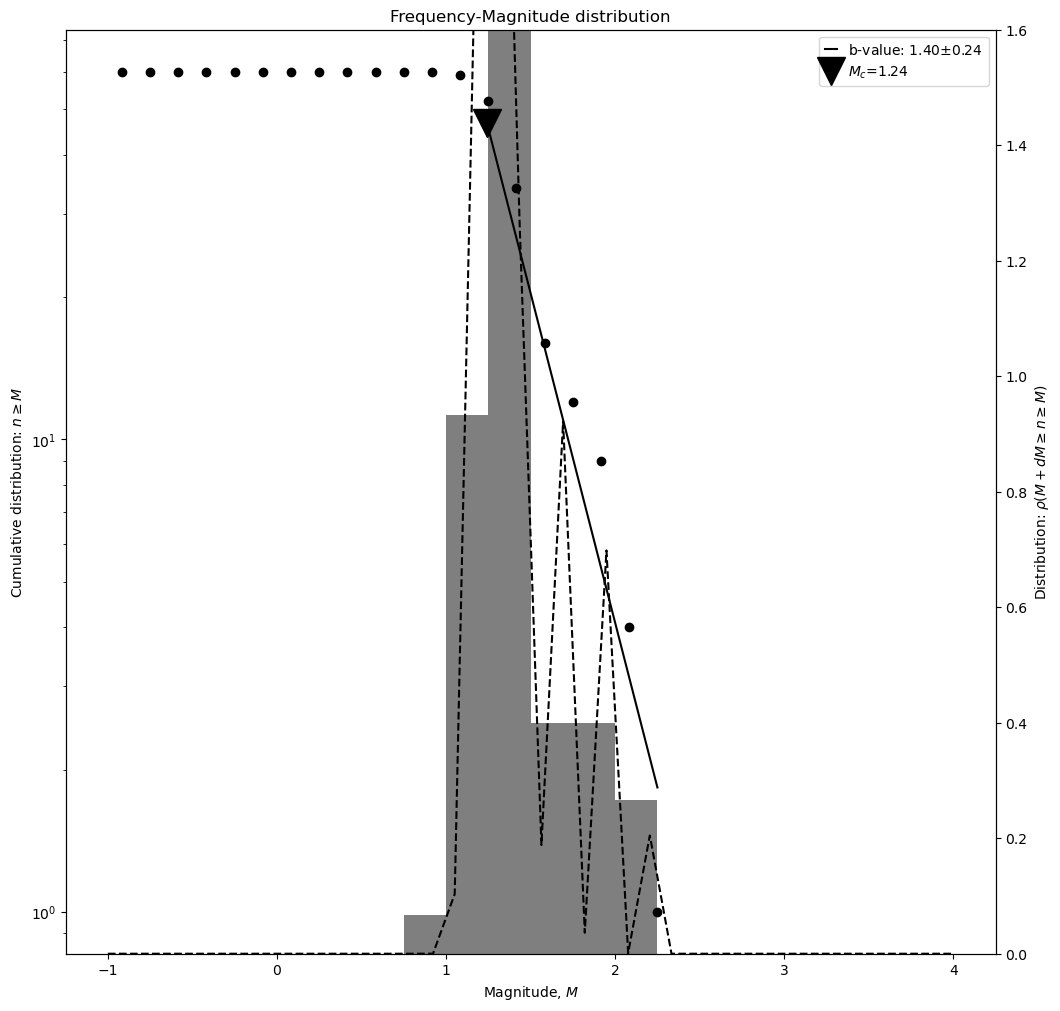

In [30]:
fig = plot_bvalue(GR)

Of course, computing the Gutenberg-Richter b-value on a such a small catalog may not make sense at all.

In [31]:
BPMF.utils.donefun()

⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
    ⠀⠀⠀⠀⠀⠀⢀⡤⣤⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⡀⠀⠀⠀⠀⠀⠀
    ⠀⠀⠀⠀⠀⢀⡏⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⣀⠴⠋⠉⠉⡆⠀⠀⠀⠀⠀
    ⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠈⠉⠉⠙⠓⠚⠁⠀⠀⠀⠀⣿⠀⠀⠀⠀⠀
    ⠀⠀⠀⠀⢀⠞⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣄⠀⠀⠀⠀
    ⠀⠀⠀⠀⡞⠀⠀⠀⠀⠀⠶⠀⠀⠀⠀⠀⠀⠦⠀⠀⠀⠀⠀⠸⡆⠀⠀⠀
    ⢠⣤⣶⣾⣧⣤⣤⣀⡀⠀⠀⠀⠀⠈⠀⠀⠀⢀⡤⠴⠶⠤⢤⡀⣧⣀⣀⠀
    ⠻⠶⣾⠁⠀⠀⠀⠀⠙⣆⠀⠀⠀⠀⠀⠀⣰⠋⠀⠀⠀⠀⠀⢹⣿⣭⣽⠇
    ⠀⠀⠙⠤⠴⢤⡤⠤⠤⠋⠉⠉⠉⠉⠉⠉⠉⠳⠖⠦⠤⠶⠦⠞⠁⠀⠀⠀
                ⠀ALL DONE!⠀⠀⠀
    
